In [1]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

# Suppress expected warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.cluster._supervised')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_selection')

# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

def reduce_tokens_simple_truncation(text, tokenizer, max_length=512):
    """
    Simply truncate text to the maximum allowed token length.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text
    """
    tokens = tokenizer(text, truncation=True, max_length=max_length)
    return tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)

def reduce_tokens_smart_truncation(text, tokenizer, max_length=512):
    """
    Intelligently truncate text by keeping the beginning and end portions.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text with beginning and end portions
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Keep beginning and end portions (prioritize beginning slightly)
    beginning_length = max_length // 2 + 50  # Keep slightly more from beginning
    end_length = max_length - beginning_length - 1  # Reserve 1 for separator
    
    beginning_tokens = tokens[:beginning_length]
    end_tokens = tokens[-end_length:]
    
    # Combine with a separator token
    beginning_text = tokenizer.decode(beginning_tokens, skip_special_tokens=True)
    end_text = tokenizer.decode(end_tokens, skip_special_tokens=True)
    
    return f"{beginning_text} [...] {end_text}"

def reduce_tokens_extractive_summarization(text, tokenizer, max_length=512):
    """
    Reduce text length using extractive summarization techniques.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Summarized text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Import NLTK for sentence tokenization
    try:
        import nltk
        from nltk.tokenize import sent_tokenize
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
    except ImportError:
        # If NLTK is not available, fall back to smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Split text into sentences
    sentences = sent_tokenize(text)
    
    if len(sentences) <= 3:
        # Not enough sentences to summarize meaningfully, use smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Get sentence token lengths
    sentence_tokens = []
    for sentence in sentences:
        tokens = tokenizer(sentence, return_tensors="pt")["input_ids"][0]
        sentence_tokens.append((sentence, len(tokens)))
    
    # Calculate target ratio based on max length vs total length
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    reduction_ratio = max_length / len(tokens)
    
    # Always keep first and last sentences
    first_sentence, first_len = sentence_tokens[0]
    last_sentence, last_len = sentence_tokens[-1]
    
    remaining_length = max_length - first_len - last_len - 10  # Reserve some tokens for separators
    
    # If can't even fit first and last sentences, use smart truncation
    if remaining_length <= 0:
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Choose middle sentences based on importance (for now, just choose evenly distributed sentences)
    middle_sentences = sentence_tokens[1:-1]
    
    # Calculate how many middle sentences we can include
    middle_sentences_to_keep = []
    current_length = 0
    
    # Select sentences in a distributed manner
    if len(middle_sentences) > 0:
        # Fix: Add a check to prevent division by zero
        sentences_to_keep = int(reduction_ratio * len(middle_sentences))
        if sentences_to_keep <= 0:
            step = len(middle_sentences) + 1  # This will select only the first sentence if any
        else:
            step = max(1, len(middle_sentences) // sentences_to_keep)
            
        for i in range(0, len(middle_sentences), step):
            sentence, length = middle_sentences[i]
            if current_length + length <= remaining_length:
                middle_sentences_to_keep.append(sentence)
                current_length += length
            else:
                break
    
    # Combine sentences
    summarized_text = first_sentence
    
    if middle_sentences_to_keep:
        summarized_text += " " + " ".join(middle_sentences_to_keep)
    
    summarized_text += " " + last_sentence
    
    # Verify final length is within limit
    final_tokens = tokenizer(summarized_text, truncation=False, return_tensors="pt")["input_ids"][0]
    if len(final_tokens) > max_length:
        # Fall back to smart truncation if still too long
        return reduce_tokens_smart_truncation(summarized_text, tokenizer, max_length)
    
    return summarized_text

def reduce_tokens_hybrid(text, tokenizer, max_length=512):
    """
    Use a hybrid approach combining extractive summarization and smart truncation.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Processed text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # For very long documents, use extractive summarization first
    if len(tokens) > max_length * 2:
        summarized = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        summarized_tokens = tokenizer(summarized, truncation=False, return_tensors="pt")["input_ids"][0]
        
        # If still too long, apply smart truncation
        if len(summarized_tokens) > max_length:
            return reduce_tokens_smart_truncation(summarized, tokenizer, max_length)
        return summarized
    
    # For moderately long documents, use smart truncation directly
    return reduce_tokens_smart_truncation(text, tokenizer, max_length)

def process_with_token_reduction(texts, tokenizer, max_length=512, strategy="smart_truncation"):
    """
    Process a series of texts by applying token reduction where necessary.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        max_length (int): Maximum token length (default: 512)
        strategy (str): Token reduction strategy, one of:
            - "simple": Simple truncation at max_length
            - "smart_truncation": Keep beginning and end portions
            - "extractive_summarization": Use extractive summarization
            - "hybrid": Combine summarization and smart truncation
            
    Returns:
        pd.Series: Series with processed texts
    """
    processed_texts = []
    token_lengths_before = []
    token_lengths_after = []
    
    for text in tqdm(texts, desc=f"Applying token reduction ({strategy})"):
        # Calculate original token length
        tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_before.append(len(tokens))
        
        # Only process if longer than max_length
        if len(tokens) <= max_length:
            processed_texts.append(text)
            token_lengths_after.append(len(tokens))
            continue
        
        # Apply selected strategy
        if strategy == "simple":
            processed_text = reduce_tokens_simple_truncation(text, tokenizer, max_length)
        elif strategy == "smart_truncation":
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        elif strategy == "extractive_summarization":
            processed_text = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        elif strategy == "hybrid":
            processed_text = reduce_tokens_hybrid(text, tokenizer, max_length)
        else:
            # Default to smart truncation
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        
        processed_texts.append(processed_text)
        
        # Calculate new token length
        new_tokens = tokenizer(processed_text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_after.append(len(new_tokens))
    
    # Print statistics
    print(f"\nToken reduction statistics using {strategy} strategy:")
    print(f"  Before:")
    print(f"    Mean length: {np.mean(token_lengths_before):.2f}")
    print(f"    Median length: {np.median(token_lengths_before):.2f}")
    print(f"    Max length: {max(token_lengths_before)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_before if l > max_length)} ({sum(1 for l in token_lengths_before if l > max_length)/len(token_lengths_before)*100:.2f}%)")
    
    print(f"  After:")
    print(f"    Mean length: {np.mean(token_lengths_after):.2f}")
    print(f"    Median length: {np.median(token_lengths_after):.2f}")
    print(f"    Max length: {max(token_lengths_after)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_after if l > max_length)} ({sum(1 for l in token_lengths_after if l > max_length)/len(token_lengths_after)*100:.2f}%)")
    
    # Optional: Create histogram plot
    try:
        plt.figure(figsize=(10, 6))
        plt.hist([token_lengths_before, token_lengths_after], bins=30, 
                 label=['Before reduction', 'After reduction'], alpha=0.7)
        plt.axvline(x=max_length, color='r', linestyle='--', label=f'Max length ({max_length})')
        plt.title(f'Token Length Distribution Before and After {strategy}')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig(f'token_reduction_{strategy}.png')
        plt.close()
        print(f"  Distribution plot saved as token_reduction_{strategy}.png")
    except Exception as e:
        print(f"  Could not create distribution plot: {str(e)}")
    
    return pd.Series(processed_texts, index=texts.index)

def calculate_token_lengths(texts, tokenizer):
    """
    Calculate the token length for each text sample using the specified tokenizer.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        
    Returns:
        pd.Series: Series containing the token length of each text
    """
    token_lengths = []
    for text in tqdm(texts, desc="Calculating token lengths"):
        tokens = tokenizer(str(text), truncation=False, return_tensors="pt")
        token_lengths.append(len(tokens['input_ids'][0]))
    
    return pd.Series(token_lengths, index=texts.index)

def filter_outliers_by_token_length(texts, token_lengths, std_threshold=3.0, min_token_threshold=None):
    """
    Filter out text samples with token lengths beyond a certain standard deviation threshold.
    
    Args:
        texts (pd.Series): Series of input texts
        token_lengths (pd.Series): Series containing token length of each text
        std_threshold (float): Standard deviation threshold (default: 3.0)
        min_token_threshold (int, optional): Minimum number of tokens required (default: None)
        
    Returns:
        tuple: Filtered texts and boolean mask to apply to original data
    """
    mean_length = token_lengths.mean()
    std_length = token_lengths.std()
    
    # Print original token statistics
    print(f"Token length statistics before filtering:")
    print(f"  Mean: {mean_length:.2f}, Std Dev: {std_length:.2f}")
    print(f"  Min: {token_lengths.min()}, Max: {token_lengths.max()}")
    print(f"  25th percentile: {token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {token_lengths.quantile(0.75):.2f}")
    
    # Original data size
    original_size = len(texts)
    
    # Start with all True mask for the original data
    final_mask = pd.Series(True, index=texts.index)
    
    # Step 1: Apply standard deviation filtering if std_threshold is provided
    if std_threshold < float('inf'):
        # Define upper and lower bounds
        upper_bound = mean_length + std_threshold * std_length
        lower_bound = mean_length - std_threshold * std_length
        lower_bound = max(1, lower_bound)  # Ensure lower bound is at least 1
        
        # Create mask for samples within bounds
        std_mask = (token_lengths >= lower_bound) & (token_lengths <= upper_bound)
        
        # Update final mask with standard deviation condition
        final_mask = final_mask & std_mask
        
        std_removed = (~std_mask).sum()
        print(f"Applied {std_threshold} std dev threshold: ({lower_bound:.2f}, {upper_bound:.2f})")
        print(f"Removed {std_removed} samples by std dev filtering ({std_removed/original_size*100:.2f}% of data)")
    
    # Step 2: Apply minimum token threshold if specified
    if min_token_threshold is not None:
        # Create mask for minimum token threshold
        min_token_mask = token_lengths >= min_token_threshold
        
        # Track how many would be removed by this filter
        min_token_removed = (~min_token_mask).sum()
        
        # Track how many would be removed by this filter that weren't already filtered by std
        additional_removed = ((~min_token_mask) & final_mask).sum()
        
        # Update final mask with minimum token threshold condition
        final_mask = final_mask & min_token_mask
        
        print(f"Applied minimum token threshold of {min_token_threshold}")
        print(f"Removed {min_token_removed} samples below minimum token threshold ({min_token_removed/original_size*100:.2f}% of original data)")
        print(f"Of which {additional_removed} weren't already filtered by std deviation ({additional_removed/original_size*100:.2f}% of original data)")
    
    # Apply final mask to get filtered data
    filtered_texts = texts[final_mask]
    filtered_token_lengths = token_lengths[final_mask]
    
    # Calculate total removed
    total_removed = (~final_mask).sum()
    print(f"Total removed: {total_removed} samples ({total_removed/original_size*100:.2f}% of original data)")
    print(f"Remaining: {final_mask.sum()} samples ({final_mask.sum()/original_size*100:.2f}% of original data)")

    # Print final statistics
    print(f"\nToken length statistics after all filtering:")
    print(f"  Mean: {filtered_token_lengths.mean():.2f}, Std Dev: {filtered_token_lengths.std():.2f}")
    print(f"  Min: {filtered_token_lengths.min()}, Max: {filtered_token_lengths.max()}")
    print(f"  25th percentile: {filtered_token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {filtered_token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {filtered_token_lengths.quantile(0.75):.2f}")
    
    return filtered_texts, final_mask

class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
    
class DeBERTaClassifier(nn.Module):
    """
    A classifier model based on DeBERTa for multi-label classification.
    
    This model uses a pre-trained DeBERTa model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in DeBERTa
        for param in self.deberta.parameters():
            param.requires_grad = False
        # Unfreeze encoder parameters for fine-tuning
        # Note: DeBERTa has a different architecture than BERT/RoBERTa
        # We'll unfreeze the last 3 encoder layers
        for layer in self.deberta.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Unlike BERT, DeBERTa doesn't have a pooler, so we need to take the last hidden state
        # and either use the [CLS] token (first token) or do mean pooling
        # Here we'll use the [CLS] token (first token) representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(cls_output)
    
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
    

def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0, tokenizer=None, token_std_threshold=None, min_token_threshold=None):
    """
    Filter out infrequent labels, samples with too many labels, and token length outliers.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.
        tokenizer: Tokenizer to use for token length calculation (required if token_std_threshold is provided)
        token_std_threshold (float, optional): Standard deviation threshold for filtering token length outliers.
            If None, no token length filtering is applied. Common values are 2.0 or 3.0.
        min_token_threshold (int, optional): Minimum number of tokens required for a sample.
            If None, no minimum token threshold is applied.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Print initial dataset size
    initial_size = len(df)
    print(f"\n=== DATA PREPROCESSING STATISTICS ===")
    print(f"Initial dataset size: {initial_size}")
    
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        before_nan_filter = len(df)
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
        nan_removed = before_nan_filter - len(df)
        if nan_removed > 0:
            print(f"Step 1: Removed {nan_removed} rows with 'nan' text ({nan_removed/before_nan_filter*100:.2f}% of data)")
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    before_na_drop = len(df)
    df = df.dropna()
    na_removed = before_na_drop - len(df)
    if na_removed > 0:
        print(f"Step 2: Removed {na_removed} rows with missing labels ({na_removed/before_na_drop*100:.2f}% of data)")
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    current_size = len(texts)
    print(f"Dataset size after basic cleaning: {current_size} ({current_size/initial_size*100:.2f}% of original data)")

    # Filter by token length if requested
    if (token_std_threshold is not None or min_token_threshold is not None) and tokenizer is not None:
        print(f"\nStep 3: Filtering by token length...")
        if token_std_threshold is not None:
            print(f"Using {token_std_threshold} standard deviation threshold")
        if min_token_threshold is not None:
            print(f"Using minimum token threshold of {min_token_threshold}")
        
        # Calculate token lengths
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # Apply token length filtering
        before_token_filter = len(texts)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=min_token_threshold
        )
        # Apply same filter to labels
        filtered_labels = labels[token_mask].reset_index(drop=True)
        token_removed = before_token_filter - len(filtered_texts)
        print(f"Removed {token_removed} samples by token length filtering ({token_removed/before_token_filter*100:.2f}% of data)")
        print(f"Texts after token length filtering: {len(filtered_texts)} ({len(filtered_texts)/initial_size*100:.2f}% of original data)")

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])
    total_labels_before = len(label_distribution)
    print(f"\nStep 4: Filtering infrequent labels (min frequency: {min_label_freq})")
    print(f"Total unique labels before filtering: {total_labels_before}")

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    labels_removed = total_labels_before - len(frequent_labels)
    print(f"Removed {labels_removed} infrequent labels ({labels_removed/total_labels_before*100:.2f}% of labels)")
    print(f"Number of labels remaining: {len(frequent_labels)} ({len(frequent_labels)/total_labels_before*100:.2f}% of labels)")

    # Filter out infrequent labels
    before_label_filter = len(labels)
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    
    # Count samples that have no labels after filtering
    empty_labels_mask = filtered_labels.apply(len) > 0
    empty_labels_count = (~empty_labels_mask).sum()
    if empty_labels_count > 0:
        print(f"Warning: {empty_labels_count} samples ({empty_labels_count/before_label_filter*100:.2f}%) now have no labels due to label frequency filtering")
        # Remove samples with no labels
        filtered_labels = filtered_labels[empty_labels_mask]
        texts = texts[empty_labels_mask]
        print(f"Removed {empty_labels_count} samples with no labels")
    
    print(f"Samples remaining after label filtering: {len(filtered_labels)} ({len(filtered_labels)/before_label_filter*100:.2f}% of data)")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    total_combinations_before = len(label_combinations)
    
    print(f"\nStep 5: Filtering infrequent label combinations (min frequency: {min_label_comb_freq})")
    print(f"Total unique label combinations before filtering: {total_combinations_before}")
    
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    combinations_removed = total_combinations_before - len(frequent_combinations)
    print(f"Removed {combinations_removed} infrequent label combinations ({combinations_removed/total_combinations_before*100:.2f}% of combinations)")
    print(f"Number of label combinations remaining: {len(frequent_combinations)} ({len(frequent_combinations)/total_combinations_before*100:.2f}% of combinations)")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        before_comb_filter = len(filtered_labels)
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        samples_removed_by_comb = before_comb_filter - comb_mask.sum()
        print(f"Removed {samples_removed_by_comb} samples with infrequent label combinations ({samples_removed_by_comb/before_comb_filter*100:.2f}% of data)")
        print(f"Samples remaining after combination filtering: {comb_mask.sum()} ({comb_mask.sum()/before_comb_filter*100:.2f}% of data)")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    print(f"\nStep 6: Filtering samples with too many labels (max labels per sample: {max_label_len})")
    before_length_filter = len(filtered_labels)
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    samples_removed_by_length = before_length_filter - length_mask.sum()
    print(f"Removed {samples_removed_by_length} samples with too many or zero labels ({samples_removed_by_length/before_length_filter*100:.2f}% of data)")
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"\n=== FINAL PREPROCESSING RESULTS ===")
    print(f"Original dataset size: {initial_size}")
    print(f"Final dataset size: {len(filtered_labels)} ({len(filtered_labels)/initial_size*100:.2f}% of original data)")
    print(f"Total samples removed: {initial_size - len(filtered_labels)} ({(initial_size - len(filtered_labels))/initial_size*100:.2f}% of original data)")
    
    return texts, filtered_labels



def main(args):
    """
    Main function to run the multi-label classification pipeline with DeBERTa.
    This function loads both training and testing data from CSV files, preprocesses them, 
    trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Initialize tokenizer early
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

    # Determine token standard deviation threshold from argument
    token_std_threshold = None
    if args.token_length_filter == '2std':
        token_std_threshold = 2.0
    elif args.token_length_filter == '3std':
        token_std_threshold = 3.0

    # Load training data
    print(f"Loading training data from {args.train_data_path}...")
    train_df = pd.read_csv(args.train_data_path)
    
    # Convert string representation of list to actual list for labels column
    if 'labels' in train_df.columns:
        try:
            # Safe evaluation for string representations of lists
            train_df['labels'] = train_df['labels'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.strip() not in ('', 'nan', 'None', 'NaN') else 
                          ([] if pd.isna(x) else x)
            )
        except Exception as e:
            print(f"Error processing training labels: {e}")
            print("First few labels for inspection:", train_df['labels'].head())
            raise
    else:
        raise ValueError(f"'labels' column not found in training data. Available columns: {train_df.columns.tolist()}")
    
    print(f"Loading testing data from {args.test_data_path}...")
    test_df = pd.read_csv(args.test_data_path)
    
    # Convert string representation of list to actual list for labels column
    if 'labels' in test_df.columns:
        try:
            # Safe evaluation for string representations of lists
            test_df['labels'] = test_df['labels'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.strip() not in ('', 'nan', 'None', 'NaN') else 
                          ([] if pd.isna(x) else x)
            )
        except Exception as e:
            print(f"Error processing testing labels: {e}")
            print("First few labels for inspection:", test_df['labels'].head())
            raise
    else:
        raise ValueError(f"'labels' column not found in testing data. Available columns: {test_df.columns.tolist()}")
    
    # Check if the text column exists in both datasets
    if args.text_column not in train_df.columns or args.text_column not in test_df.columns:
        available_columns_train = [col for col in train_df.columns if col.startswith('all_text')]
        available_columns_test = [col for col in test_df.columns if col.startswith('all_text')]
        common_columns = list(set(available_columns_train) & set(available_columns_test))
        
        print(f"Text column '{args.text_column}' not found in both datasets.")
        print(f"Common text columns: {common_columns}")
        
        if len(common_columns) == 0:
            raise ValueError("No common text columns found in both datasets")
        
        args.text_column = common_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Process training data
    print("\n=== PROCESSING TRAINING DATA ===")
    
    # Extract issue texts and labels from training data
    train_texts = train_df[args.text_column]
    train_labels = train_df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Apply token length filtering to training data if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering to training data...")
        token_lengths = calculate_token_lengths(train_texts, tokenizer)
        
        # Filter by standard deviation, then by min threshold (in sequence)
        filtered_train_texts, token_mask = filter_outliers_by_token_length(
            train_texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        
        # Apply same filter to labels and dataframe
        filtered_train_labels = train_labels[token_mask]
        filtered_train_df = train_df[token_mask]
        
        # Reset indices for further processing
        train_texts = filtered_train_texts.reset_index(drop=True)
        train_labels = filtered_train_labels.reset_index(drop=True)
        filtered_train_df = filtered_train_df.reset_index(drop=True)
    else:
        filtered_train_df = train_df
    
    # Apply token reduction to training data if requested
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy to training data: {args.token_reduction_strategy}")
        train_texts = process_with_token_reduction(
            train_texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_train_df with the reduced texts
        filtered_train_df[args.text_column] = train_texts
    
    # Use prepare_data to filter and prepare training data
    train_texts, train_filtered_labels = prepare_data(
        filtered_train_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Skip token filtering as we've done it
        min_token_threshold=None   # Skip token threshold as we've done it
    )
    
    # Print training dataset statistics
    print("\n=== TRAINING DATASET STATISTICS ===")
    print(f"Initial training dataset size: {len(train_df)}")
    print(f"Final training dataset size: {len(train_texts)}")
    print(f"Total samples removed: {len(train_df) - len(train_texts)} ({(len(train_df) - len(train_texts))/len(train_df)*100:.2f}% of original training data)")
    
    # Count the number of labels distribution in training data
    train_label_distribution = Counter([label for labels in train_filtered_labels for label in labels])
    print('\nTraining Label Distribution:')
    for i, (label, count) in enumerate(sorted(train_label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Process testing data
    print("\n=== PROCESSING TESTING DATA ===")
    
    # Extract issue texts and labels from testing data
    test_texts = test_df[args.text_column]
    test_labels = test_df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Apply token length filtering to testing data if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering to testing data...")
        token_lengths = calculate_token_lengths(test_texts, tokenizer)
        
        # Use the same filtering parameters as for training data
        filtered_test_texts, token_mask = filter_outliers_by_token_length(
            test_texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        
        # Apply same filter to labels and dataframe
        filtered_test_labels = test_labels[token_mask]
        filtered_test_df = test_df[token_mask]
        
        # Reset indices for further processing
        test_texts = filtered_test_texts.reset_index(drop=True)
        test_labels = filtered_test_labels.reset_index(drop=True)
        filtered_test_df = filtered_test_df.reset_index(drop=True)
    else:
        filtered_test_df = test_df
    
    # Apply token reduction to testing data if requested
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy to testing data: {args.token_reduction_strategy}")
        test_texts = process_with_token_reduction(
            test_texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_test_df with the reduced texts
        filtered_test_df[args.text_column] = test_texts
    
    # Use prepare_data to filter and prepare testing data
    # Note: We use the same min_label_freq, max_label_len etc. as training data for consistency
    test_texts, test_filtered_labels = prepare_data(
        filtered_test_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Skip token filtering as we've done it
        min_token_threshold=None   # Skip token threshold as we've done it
    )
    
    # Print testing dataset statistics
    print("\n=== TESTING DATASET STATISTICS ===")
    print(f"Initial testing dataset size: {len(test_df)}")
    print(f"Final testing dataset size: {len(test_texts)}")
    print(f"Total samples removed: {len(test_df) - len(test_texts)} ({(len(test_df) - len(test_texts))/len(test_df)*100:.2f}% of original testing data)")
    
    # Save preprocessing metadata
    preprocessing_metadata = {
        'data_format': 'csv',
        'data_paths': {
            'train': args.train_data_path,
            'test': args.test_data_path
        },
        'initial_dataset_sizes': {
            'train': len(train_df),
            'test': len(test_df)
        },
        'final_dataset_sizes': {
            'train': len(train_texts),
            'test': len(test_texts)
        },
        'token_reduction': {
            'applied': args.token_reduction_strategy is not None,
            'strategy': args.token_reduction_strategy if args.token_reduction_strategy else None,
            'max_length': args.max_length
        },
        'token_length_filtering': {
            'applied': token_std_threshold is not None,
            'threshold': token_std_threshold
        },
        'label_filtering': {
            'min_label_freq': args.min_label_freq,
            'max_label_len': args.max_label_len,
            'min_label_comb_freq': args.min_label_comb_freq
        },
        'min_token_threshold': {
            'applied': args.min_token_threshold is not None,
            'threshold': args.min_token_threshold
        }
    }
    
    # Explicitly calculate token lengths after preparation for metadata
    print("Calculating final token lengths for metadata...")
    train_token_lengths = calculate_token_lengths(train_texts, tokenizer)
    test_token_lengths = calculate_token_lengths(test_texts, tokenizer)
    
    # Calculate and add token statistics to metadata
    if tokenizer is not None:
        preprocessing_metadata['token_stats'] = {
            'train': {
                'max_token_length': int(train_token_lengths.max()),
                'mean_token_length': float(train_token_lengths.mean()),
                'median_token_length': float(train_token_lengths.median())
            },
            'test': {
                'max_token_length': int(test_token_lengths.max()),
                'mean_token_length': float(test_token_lengths.mean()),
                'median_token_length': float(test_token_lengths.median())
            }
        }
        
        print(f"\n=== TOKEN LENGTH SUMMARY ===")
        print(f"Training set:")
        print(f"  Maximum token length: {train_token_lengths.max()}")
        print(f"  Mean token length: {train_token_lengths.mean():.2f}")
        print(f"  Median token length: {train_token_lengths.median():.2f}")
        
        print(f"Testing set:")
        print(f"  Maximum token length: {test_token_lengths.max()}")
        print(f"  Mean token length: {test_token_lengths.mean():.2f}")
        print(f"  Median token length: {test_token_lengths.median():.2f}")
    
    with open(os.path.join(run_dir, 'preprocessing_metadata.json'), 'w') as f:
        json.dump(preprocessing_metadata, f, indent=4)
    
    # Encode multi-labels using MultiLabelBinarizer - fit on training data only
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    train_labels_encoded = mlb.fit_transform(train_filtered_labels)
    
    # Transform test labels using the same encoder
    test_labels_encoded = mlb.transform(test_filtered_labels)
    
    # Save all original label classes
    all_classes = mlb.classes_.tolist()
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': all_classes
        }, f)
    
    # Calculate label distribution
    label_counts = train_labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics for training set
    label_density = label_counts.sum() / (train_labels_encoded.shape[0] * train_labels_encoded.shape[1])
    print(f"Training set label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / train_labels_encoded.shape[0]:.2f}")
    
    # Print feature selection args
    use_label_selection = args.use_predefined_labels or args.use_10_labels
    print(f"Using predefined labels: {use_label_selection}")
    
    # Handle label selection - 10 labels takes precedence if both options are specified
    if args.use_10_labels or args.use_predefined_labels:
        if args.use_10_labels:
            print(f"\nUsing predefined list of 10 labels...")
            
            # Predefined list of 10 specific labels to use
            predefined_labels = np.array([
                'area/e2e-test-framework', 'area/apiserver', 'area/kubeadm',
                'area/cloudprovider', 'area/test', 'area/kubectl', 'area/kubelet',
                'area/code-generation', 'area/provider/azure', 'area/kubelet-api'
            ])
            
            print(f"Using {len(predefined_labels)} selected labels: {predefined_labels}")
        
        # Optionally use a predefined list of 15 labels
        elif args.use_predefined_labels:
            print(f"\nUsing predefined list of 15 labels...")
            
            # Predefined list of labels to use
            predefined_labels = np.array([
               'area/e2e-test-framework', 'area/apiserver', 'area/kubeadm',
                'area/cloudprovider', 'area/test', 'area/kubectl', 'area/kubelet',
                'area/code-generation', 'area/provider/azure', 'area/kubelet-api',
                'area/ipvs', 'area/kube-proxy', 'area/dependency', 'area/conformance',
                'area/provider/gcp'
            ])
            
            print(f"Using {len(predefined_labels)} predefined labels: {predefined_labels}")
        
        # Find indices of predefined labels in the mlb.classes_
        selected_indices = []
        selected_labels = []
        
        for label in predefined_labels:
            if label in mlb.classes_:
                idx = np.where(mlb.classes_ == label)[0][0]
                selected_indices.append(idx)
                selected_labels.append(label)
        
        selected_indices = np.array(selected_indices)
        selected_labels = np.array(selected_labels)
        
        # In case some labels are not found, inform the user
        if len(selected_labels) < len(predefined_labels):
            missing_labels = set(predefined_labels) - set(selected_labels)
            print(f"Warning: {len(missing_labels)} labels were not found in the dataset: {missing_labels}")
            
        # If no labels were found, raise an error
        if len(selected_indices) == 0:
            raise ValueError("None of the predefined labels were found in the dataset!")
        
        # Filter labels_encoded to keep only selected labels
        train_labels_encoded = train_labels_encoded[:, selected_indices]
        test_labels_encoded = test_labels_encoded[:, selected_indices]
        
        # Remove samples with no labels after filtering
        train_samples_with_labels = np.sum(train_labels_encoded, axis=1) > 0
        test_samples_with_labels = np.sum(test_labels_encoded, axis=1) > 0
        
        # Calculate how many samples will be removed
        train_samples_removed = np.sum(~train_samples_with_labels)
        test_samples_removed = np.sum(~test_samples_with_labels)
        
        print(f"Removing samples with no labels after filtering:")
        print(f"  Training: {train_samples_removed} samples removed ({train_samples_removed/len(train_samples_with_labels)*100:.2f}% of data)")
        print(f"  Testing: {test_samples_removed} samples removed ({test_samples_removed/len(test_samples_with_labels)*100:.2f}% of data)")
        
        # Filter out samples with no labels
        if train_samples_removed > 0:
            train_texts = train_texts[train_samples_with_labels].reset_index(drop=True)
            train_filtered_labels = [labels for i, labels in enumerate(train_filtered_labels) if train_samples_with_labels[i]]
            train_labels_encoded = train_labels_encoded[train_samples_with_labels]
        
        if test_samples_removed > 0:
            test_texts = test_texts[test_samples_with_labels].reset_index(drop=True)
            test_filtered_labels = [labels for i, labels in enumerate(test_filtered_labels) if test_samples_with_labels[i]]
            test_labels_encoded = test_labels_encoded[test_samples_with_labels]
        
        print(f"After removing samples with no labels:")
        print(f"  Training samples: {len(train_texts)}")
        print(f"  Testing samples: {len(test_texts)}")
        
        # Save selected labels to file with removal information
        selection_method = "10_labels" if args.use_10_labels else "predefined_15_labels"
        with open(os.path.join(run_dir, 'selected_labels.json'), 'w') as f:
            json.dump({
                'selected_labels': selected_labels.tolist(),
                'selected_indices': selected_indices.tolist(),
                'selection_method': selection_method,
                'samples_removed': {
                    'train': int(train_samples_removed),
                    'test': int(test_samples_removed)
                }
            }, f)
        
        # Update mlb.classes_ to only contain selected classes
        mlb.classes_ = np.array(selected_labels)
        
        # Recalculate label counts with selected labels
        label_counts = train_labels_encoded.sum(axis=0)
        print(f"Training with {len(selected_labels)} selected labels: {selected_labels}")
    else:
        print(f"Using all {len(mlb.classes_)} labels from the dataset")
        print("Feature selection disabled, using all labels")
    
    print(f"Final dataset sizes - Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
    
    # Add label selection info to preprocessing metadata
    if args.use_10_labels or args.use_predefined_labels:
        preprocessing_metadata['label_selection'] = {
            'method': '10_labels' if args.use_10_labels else 'predefined_15_labels',
            'selected_labels': selected_labels.tolist(),
            'samples_with_no_labels_removed': {
                'train': int(train_samples_removed) if 'train_samples_removed' in locals() else 0,
                'test': int(test_samples_removed) if 'test_samples_removed' in locals() else 0
            }
        }
    
    # Update preprocessing metadata with the latest numbers after label filtering
    preprocessing_metadata['final_dataset_sizes']['train'] = len(train_texts)
    preprocessing_metadata['final_dataset_sizes']['test'] = len(test_texts)
    with open(os.path.join(run_dir, 'preprocessing_metadata.json'), 'w') as f:
        json.dump(preprocessing_metadata, f, indent=4)
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (train_labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels_encoded, tokenizer, max_length=args.max_length)
    test_dataset = IssueDataset(test_texts, test_labels_encoded, tokenizer, max_length=args.max_length)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = DeBERTaClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    test_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Evaluate on test data
        test_loss, accuracy_metrics, test_precision, test_recall, test_f1 = validate(
            model, test_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Test Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Test Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if test_f1 > best_f1:
            best_f1 = test_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'test_losses': test_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, test_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'data_format': 'csv',
        'train_data': os.path.basename(args.train_data_path),
        'test_data': os.path.basename(args.test_data_path),
        'text_column': args.text_column,
        'token_length_filter': args.token_length_filter,
        'token_reduction_strategy': args.token_reduction_strategy,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_test_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_test_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_test_labels = np.vstack(all_test_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_test_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

2025-05-06 18:01:35.278263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746554495.530715      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746554495.609506      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Full Labels

Max labels length 5

Using 2 GPUs: [0, 1]
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

Loading training data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv...
Loading testing data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 4180/4180 [00:20<00:00, 207.98it/s]


Token length statistics before filtering:
  Mean: 355.03, Std Dev: 114.74
  Min: 23, Max: 1275
  25th percentile: 323.00
  50th percentile (median): 359.00
  75th percentile: 406.00
Applied 3.0 std dev threshold: (10.80, 699.26)
Removed 45 samples by std dev filtering (1.08% of data)
Total removed: 45 samples (1.08% of original data)
Remaining: 4135 samples (98.92% of original data)

Token length statistics after all filtering:
  Mean: 348.87, Std Dev: 96.97
  Min: 23, Max: 699
  25th percentile: 322.00
  50th percentile (median): 358.00
  75th percentile: 404.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 4135
Dataset size after basic cleaning: 4135 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 4135 (100.00% of data)

Step 5: Filtering infrequent label com

Calculating token lengths: 100%|██████████| 165/165 [00:00<00:00, 504.42it/s]


Token length statistics before filtering:
  Mean: 316.14, Std Dev: 259.63
  Min: 21, Max: 1305
  25th percentile: 132.00
  50th percentile (median): 218.00
  75th percentile: 402.00
Applied 3.0 std dev threshold: (1.00, 1095.03)
Removed 3 samples by std dev filtering (1.82% of data)
Total removed: 3 samples (1.82% of original data)
Remaining: 162 samples (98.18% of original data)

Token length statistics after all filtering:
  Mean: 298.48, Std Dev: 226.68
  Min: 21, Max: 859
  25th percentile: 132.00
  50th percentile (median): 208.50
  75th percentile: 385.25

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 162
Dataset size after basic cleaning: 162 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 13
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 13 (100.00% of labels)
Samples remaining after label filtering: 162 (100.00% of data)

Step 5: Filtering infrequent label combinat

Calculating token lengths: 100%|██████████| 149/149 [00:00<00:00, 514.35it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 699
  Mean token length: 348.51
  Median token length: 358.00
Testing set:
  Maximum token length: 859
  Mean token length: 294.36
  Median token length: 208.00
Encoding labels...
Training set label density: 0.0587
Average labels per sample: 1.06
Using predefined labels: False
Using all 18 labels from the dataset
Feature selection disabled, using all labels
Final dataset sizes - Training samples: 4102, Testing samples: 149
Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20



Training: 100%|██████████| 129/129 [02:56<00:00,  1.37s/it]


Train Loss: 0.2799, Train Accuracy (Exact Match): 0.0032
Test Loss: 0.2193
Test Accuracy (Exact Match): 0.1007
Test Accuracy (Partial Match): 0.1831
Test Accuracy (Jaccard): 0.1831
Test Precision: 0.2953, Test Recall: 0.1831, Test F1: 0.2145
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 2/20


Training: 100%|██████████| 129/129 [03:05<00:00,  1.44s/it]


Train Loss: 0.1410, Train Accuracy (Exact Match): 0.2526
Test Loss: 0.2098
Test Accuracy (Exact Match): 0.1477
Test Accuracy (Partial Match): 0.2767
Test Accuracy (Jaccard): 0.2767
Test Precision: 0.4564, Test Recall: 0.2767, Test F1: 0.3268
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 3/20


Training: 100%|██████████| 129/129 [03:08<00:00,  1.46s/it]


Train Loss: 0.0801, Train Accuracy (Exact Match): 0.7065
Test Loss: 0.1933
Test Accuracy (Exact Match): 0.2148
Test Accuracy (Partial Match): 0.3369
Test Accuracy (Jaccard): 0.3302
Test Precision: 0.4832, Test Recall: 0.3369, Test F1: 0.3749
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 4/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0558, Train Accuracy (Exact Match): 0.8203
Test Loss: 0.1404
Test Accuracy (Exact Match): 0.5235
Test Accuracy (Partial Match): 0.6708
Test Accuracy (Jaccard): 0.6551
Test Precision: 0.7852, Test Recall: 0.6708, Test F1: 0.7004
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 5/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0427, Train Accuracy (Exact Match): 0.8588
Test Loss: 0.1239
Test Accuracy (Exact Match): 0.6107
Test Accuracy (Partial Match): 0.7279
Test Accuracy (Jaccard): 0.7234
Test Precision: 0.8591, Test Recall: 0.7279, Test F1: 0.7642
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 6/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0346, Train Accuracy (Exact Match): 0.8747
Test Loss: 0.1048
Test Accuracy (Exact Match): 0.6644
Test Accuracy (Partial Match): 0.8010
Test Accuracy (Jaccard): 0.7865
Test Precision: 0.9004, Test Recall: 0.8010, Test F1: 0.8267
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 7/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0304, Train Accuracy (Exact Match): 0.8796
Test Loss: 0.1000
Test Accuracy (Exact Match): 0.6711
Test Accuracy (Partial Match): 0.8069
Test Accuracy (Jaccard): 0.7946
Test Precision: 0.9027, Test Recall: 0.8069, Test F1: 0.8342
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 8/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0267, Train Accuracy (Exact Match): 0.8864
Test Loss: 0.0976
Test Accuracy (Exact Match): 0.6711
Test Accuracy (Partial Match): 0.8116
Test Accuracy (Jaccard): 0.7993
Test Precision: 0.9004, Test Recall: 0.8116, Test F1: 0.8368
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 9/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0245, Train Accuracy (Exact Match): 0.8949
Test Loss: 0.0938
Test Accuracy (Exact Match): 0.6980
Test Accuracy (Partial Match): 0.8267
Test Accuracy (Jaccard): 0.8144
Test Precision: 0.9049, Test Recall: 0.8267, Test F1: 0.8477
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 10/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0229, Train Accuracy (Exact Match): 0.8930
Test Loss: 0.0892
Test Accuracy (Exact Match): 0.6846
Test Accuracy (Partial Match): 0.8398
Test Accuracy (Jaccard): 0.8197
Test Precision: 0.9010, Test Recall: 0.8398, Test F1: 0.8547
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 11/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0210, Train Accuracy (Exact Match): 0.9064
Test Loss: 0.0981
Test Accuracy (Exact Match): 0.6980
Test Accuracy (Partial Match): 0.8342
Test Accuracy (Jaccard): 0.8197
Test Precision: 0.9273, Test Recall: 0.8342, Test F1: 0.8589
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 12/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0197, Train Accuracy (Exact Match): 0.9003
Test Loss: 0.0957
Test Accuracy (Exact Match): 0.6711
Test Accuracy (Partial Match): 0.8281
Test Accuracy (Jaccard): 0.8040
Test Precision: 0.8977, Test Recall: 0.8281, Test F1: 0.8434

Epoch 13/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0188, Train Accuracy (Exact Match): 0.9105
Test Loss: 0.0970
Test Accuracy (Exact Match): 0.6846
Test Accuracy (Partial Match): 0.8113
Test Accuracy (Jaccard): 0.7973
Test Precision: 0.9032, Test Recall: 0.8113, Test F1: 0.8345

Epoch 14/20


Training: 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]


Train Loss: 0.0180, Train Accuracy (Exact Match): 0.9125
Test Loss: 0.0918
Test Accuracy (Exact Match): 0.6846
Test Accuracy (Partial Match): 0.8432
Test Accuracy (Jaccard): 0.8191
Test Precision: 0.9155, Test Recall: 0.8432, Test F1: 0.8587

Epoch 15/20


Training: 100%|██████████| 129/129 [03:22<00:00,  1.57s/it]


Train Loss: 0.0168, Train Accuracy (Exact Match): 0.9154
Test Loss: 0.0898
Test Accuracy (Exact Match): 0.6846
Test Accuracy (Partial Match): 0.8532
Test Accuracy (Jaccard): 0.8247
Test Precision: 0.9088, Test Recall: 0.8532, Test F1: 0.8623
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 16/20


Training: 100%|██████████| 129/129 [03:22<00:00,  1.57s/it]


Train Loss: 0.0163, Train Accuracy (Exact Match): 0.9210
Test Loss: 0.0831
Test Accuracy (Exact Match): 0.7181
Test Accuracy (Partial Match): 0.8686
Test Accuracy (Jaccard): 0.8479
Test Precision: 0.9301, Test Recall: 0.8686, Test F1: 0.8830
Saved new best model to ./results/run_20250506_180147_all_text/best_model_all_text.pt

Epoch 17/20


Training: 100%|██████████| 129/129 [03:23<00:00,  1.58s/it]


Early stopping triggered
Train Loss: 0.0157, Train Accuracy (Exact Match): 0.9181
Test Loss: 0.0865
Test Accuracy (Exact Match): 0.6980
Test Accuracy (Partial Match): 0.8465
Test Accuracy (Jaccard): 0.8236
Test Precision: 0.9100, Test Recall: 0.8465, Test F1: 0.8602
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_19/2624682429.py:1403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.7181
Partial Match Accuracy: 0.8686
Jaccard Similarity: 0.8479
Precision: 0.9301
Recall: 0.8686
F1 Score: 0.8830

Training completed! Results saved to ./results/run_20250506_180147_all_text


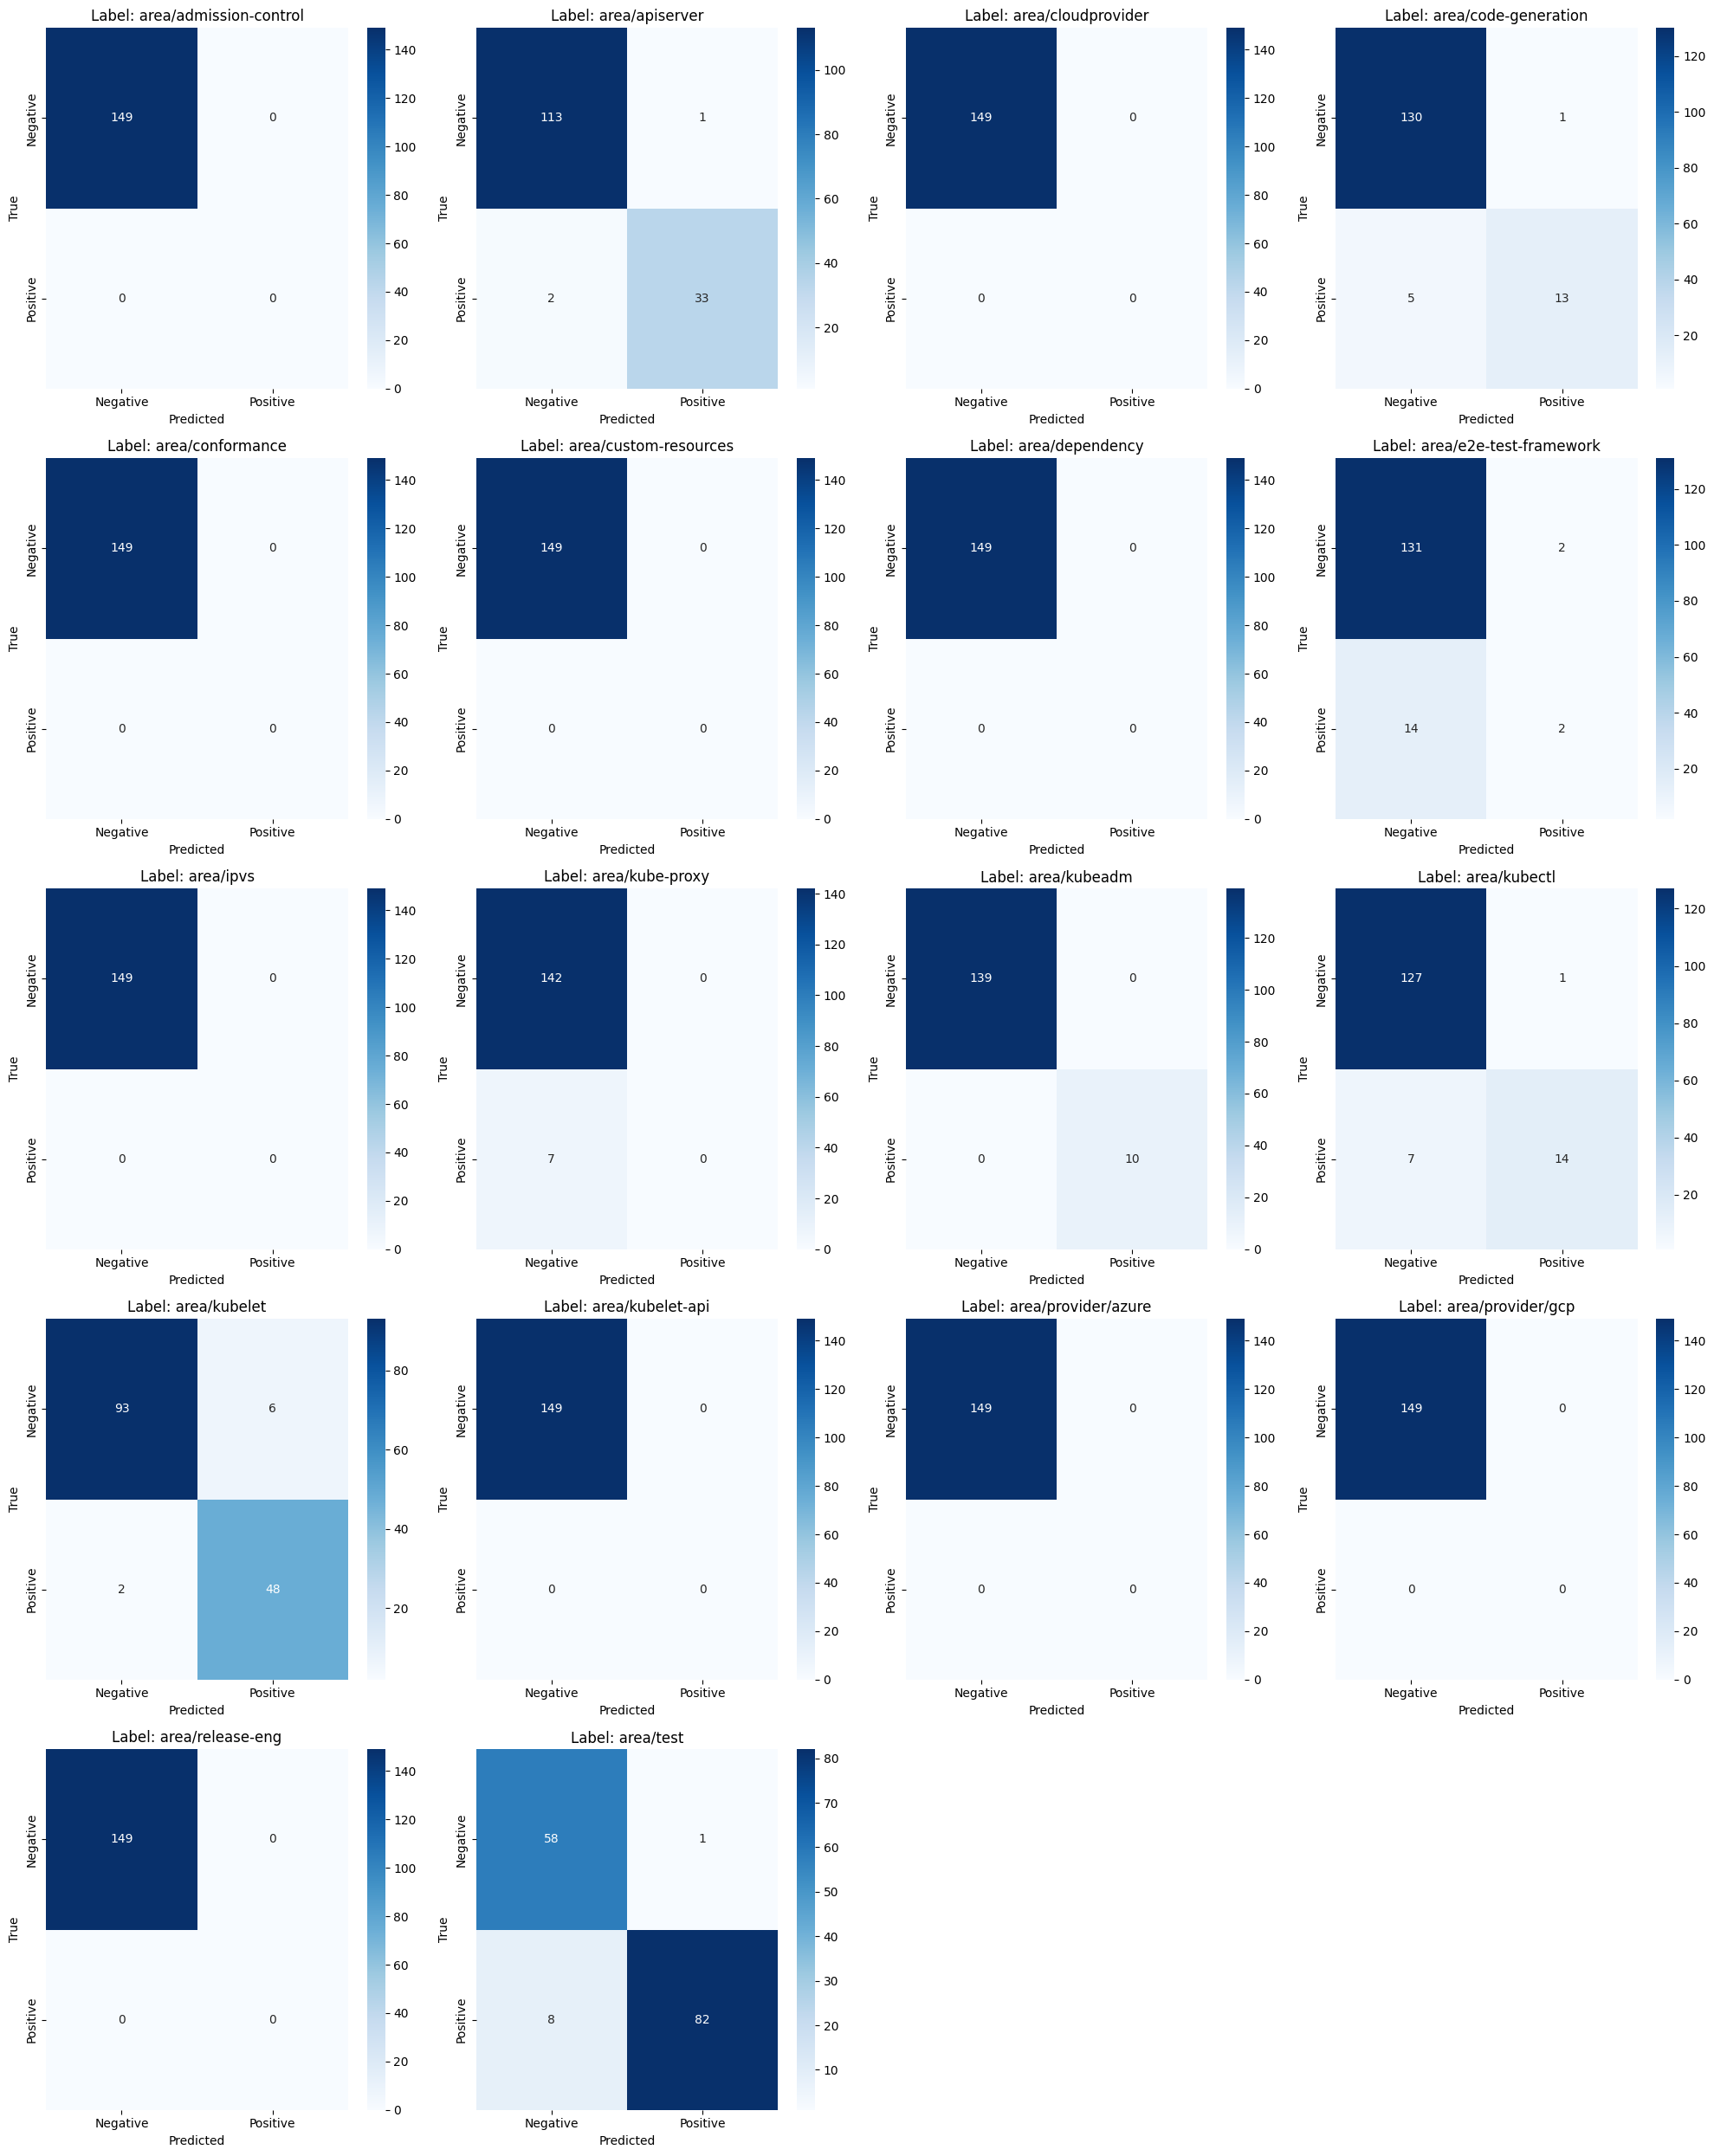

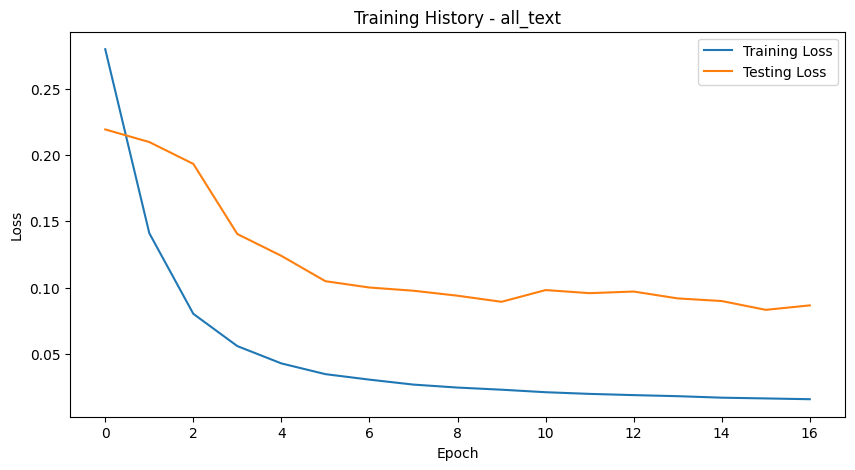

In [2]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=0,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', 
                        help='Enable predefined set of 15 labels instead of using all labels')
    parser.add_argument('--use_10_labels', action='store_true',
                        help='Enable predefined set of 10 specific labels instead of using all labels')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

Max label length 2

Using 2 GPUs: [0, 1]
Loading tokenizer...
Loading training data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv...
Loading testing data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 4180/4180 [00:19<00:00, 211.04it/s]


Token length statistics before filtering:
  Mean: 355.03, Std Dev: 114.74
  Min: 23, Max: 1275
  25th percentile: 323.00
  50th percentile (median): 359.00
  75th percentile: 406.00
Applied 3.0 std dev threshold: (10.80, 699.26)
Removed 45 samples by std dev filtering (1.08% of data)
Total removed: 45 samples (1.08% of original data)
Remaining: 4135 samples (98.92% of original data)

Token length statistics after all filtering:
  Mean: 348.87, Std Dev: 96.97
  Min: 23, Max: 699
  25th percentile: 322.00
  50th percentile (median): 358.00
  75th percentile: 404.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 4135
Dataset size after basic cleaning: 4135 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 4135 (100.00% of data)

Step 5: Filtering infrequent label com

Calculating token lengths: 100%|██████████| 165/165 [00:00<00:00, 507.74it/s]


Token length statistics before filtering:
  Mean: 316.14, Std Dev: 259.63
  Min: 21, Max: 1305
  25th percentile: 132.00
  50th percentile (median): 218.00
  75th percentile: 402.00
Applied 3.0 std dev threshold: (1.00, 1095.03)
Removed 3 samples by std dev filtering (1.82% of data)
Total removed: 3 samples (1.82% of original data)
Remaining: 162 samples (98.18% of original data)

Token length statistics after all filtering:
  Mean: 298.48, Std Dev: 226.68
  Min: 21, Max: 859
  25th percentile: 132.00
  50th percentile (median): 208.50
  75th percentile: 385.25

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 162
Dataset size after basic cleaning: 162 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 13
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 13 (100.00% of labels)
Samples remaining after label filtering: 162 (100.00% of data)

Step 5: Filtering infrequent label combinat

Calculating token lengths: 100%|██████████| 127/127 [00:00<00:00, 668.69it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 699
  Mean token length: 348.18
  Median token length: 358.00
Testing set:
  Maximum token length: 823
  Mean token length: 247.41
  Median token length: 190.00
Encoding labels...
Training set label density: 0.0578
Average labels per sample: 1.04
Using predefined labels: False
Using all 18 labels from the dataset
Feature selection disabled, using all labels
Final dataset sizes - Training samples: 4071, Testing samples: 127
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 128/128 [03:22<00:00,  1.58s/it]


Train Loss: 0.2833, Train Accuracy (Exact Match): 0.0029
Test Loss: 0.1917
Test Accuracy (Exact Match): 0.1339
Test Accuracy (Partial Match): 0.2323
Test Accuracy (Jaccard): 0.2323
Test Precision: 0.3307, Test Recall: 0.2323, Test F1: 0.2651
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 2/20


Training: 100%|██████████| 128/128 [03:15<00:00,  1.52s/it]


Train Loss: 0.1383, Train Accuracy (Exact Match): 0.2569
Test Loss: 0.1743
Test Accuracy (Exact Match): 0.0630
Test Accuracy (Partial Match): 0.1024
Test Accuracy (Jaccard): 0.1024
Test Precision: 0.1417, Test Recall: 0.1024, Test F1: 0.1155

Epoch 3/20


Training: 100%|██████████| 128/128 [03:10<00:00,  1.49s/it]


Train Loss: 0.0785, Train Accuracy (Exact Match): 0.7008
Test Loss: 0.1450
Test Accuracy (Exact Match): 0.2520
Test Accuracy (Partial Match): 0.3780
Test Accuracy (Jaccard): 0.3635
Test Precision: 0.4580, Test Recall: 0.3780, Test F1: 0.4000
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 4/20


Training: 100%|██████████| 128/128 [03:08<00:00,  1.47s/it]


Train Loss: 0.0540, Train Accuracy (Exact Match): 0.8182
Test Loss: 0.1052
Test Accuracy (Exact Match): 0.5827
Test Accuracy (Partial Match): 0.6929
Test Accuracy (Jaccard): 0.6798
Test Precision: 0.7638, Test Recall: 0.6929, Test F1: 0.7126
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 5/20


Training: 100%|██████████| 128/128 [03:08<00:00,  1.47s/it]


Train Loss: 0.0406, Train Accuracy (Exact Match): 0.8627
Test Loss: 0.0731
Test Accuracy (Exact Match): 0.7402
Test Accuracy (Partial Match): 0.8110
Test Accuracy (Jaccard): 0.8058
Test Precision: 0.8661, Test Recall: 0.8110, Test F1: 0.8281
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 6/20


Training: 100%|██████████| 128/128 [03:07<00:00,  1.46s/it]


Train Loss: 0.0340, Train Accuracy (Exact Match): 0.8747
Test Loss: 0.0646
Test Accuracy (Exact Match): 0.7559
Test Accuracy (Partial Match): 0.8386
Test Accuracy (Jaccard): 0.8281
Test Precision: 0.8898, Test Recall: 0.8386, Test F1: 0.8530
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 7/20


Training: 100%|██████████| 128/128 [03:07<00:00,  1.47s/it]


Train Loss: 0.0288, Train Accuracy (Exact Match): 0.8870
Test Loss: 0.0589
Test Accuracy (Exact Match): 0.7795
Test Accuracy (Partial Match): 0.8583
Test Accuracy (Jaccard): 0.8438
Test Precision: 0.8937, Test Recall: 0.8583, Test F1: 0.8661
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 8/20


Training: 100%|██████████| 128/128 [03:07<00:00,  1.47s/it]


Train Loss: 0.0254, Train Accuracy (Exact Match): 0.8904
Test Loss: 0.0583
Test Accuracy (Exact Match): 0.7795
Test Accuracy (Partial Match): 0.8543
Test Accuracy (Jaccard): 0.8399
Test Precision: 0.8858, Test Recall: 0.8543, Test F1: 0.8609

Epoch 9/20


Training: 100%|██████████| 128/128 [03:08<00:00,  1.47s/it]


Train Loss: 0.0235, Train Accuracy (Exact Match): 0.8981
Test Loss: 0.0542
Test Accuracy (Exact Match): 0.7717
Test Accuracy (Partial Match): 0.8504
Test Accuracy (Jaccard): 0.8360
Test Precision: 0.8858, Test Recall: 0.8504, Test F1: 0.8583

Epoch 10/20


Training: 100%|██████████| 128/128 [03:07<00:00,  1.47s/it]


Train Loss: 0.0215, Train Accuracy (Exact Match): 0.8995
Test Loss: 0.0520
Test Accuracy (Exact Match): 0.7795
Test Accuracy (Partial Match): 0.8583
Test Accuracy (Jaccard): 0.8451
Test Precision: 0.8976, Test Recall: 0.8583, Test F1: 0.8675
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 11/20


Training: 100%|██████████| 128/128 [03:07<00:00,  1.47s/it]


Train Loss: 0.0201, Train Accuracy (Exact Match): 0.9101
Test Loss: 0.0496
Test Accuracy (Exact Match): 0.7874
Test Accuracy (Partial Match): 0.8622
Test Accuracy (Jaccard): 0.8491
Test Precision: 0.8976, Test Recall: 0.8622, Test F1: 0.8701
Saved new best model to ./results/run_20250506_185825_all_text/best_model_all_text.pt

Epoch 12/20


Training: 100%|██████████| 128/128 [03:07<00:00,  1.47s/it]


Early stopping triggered
Train Loss: 0.0191, Train Accuracy (Exact Match): 0.9089
Test Loss: 0.0545
Test Accuracy (Exact Match): 0.7717
Test Accuracy (Partial Match): 0.8583
Test Accuracy (Jaccard): 0.8438
Test Precision: 0.9016, Test Recall: 0.8583, Test F1: 0.8688
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_19/2624682429.py:1403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.7874
Partial Match Accuracy: 0.8622
Jaccard Similarity: 0.8491
Precision: 0.8976
Recall: 0.8622
F1 Score: 0.8701

Training completed! Results saved to ./results/run_20250506_185825_all_text


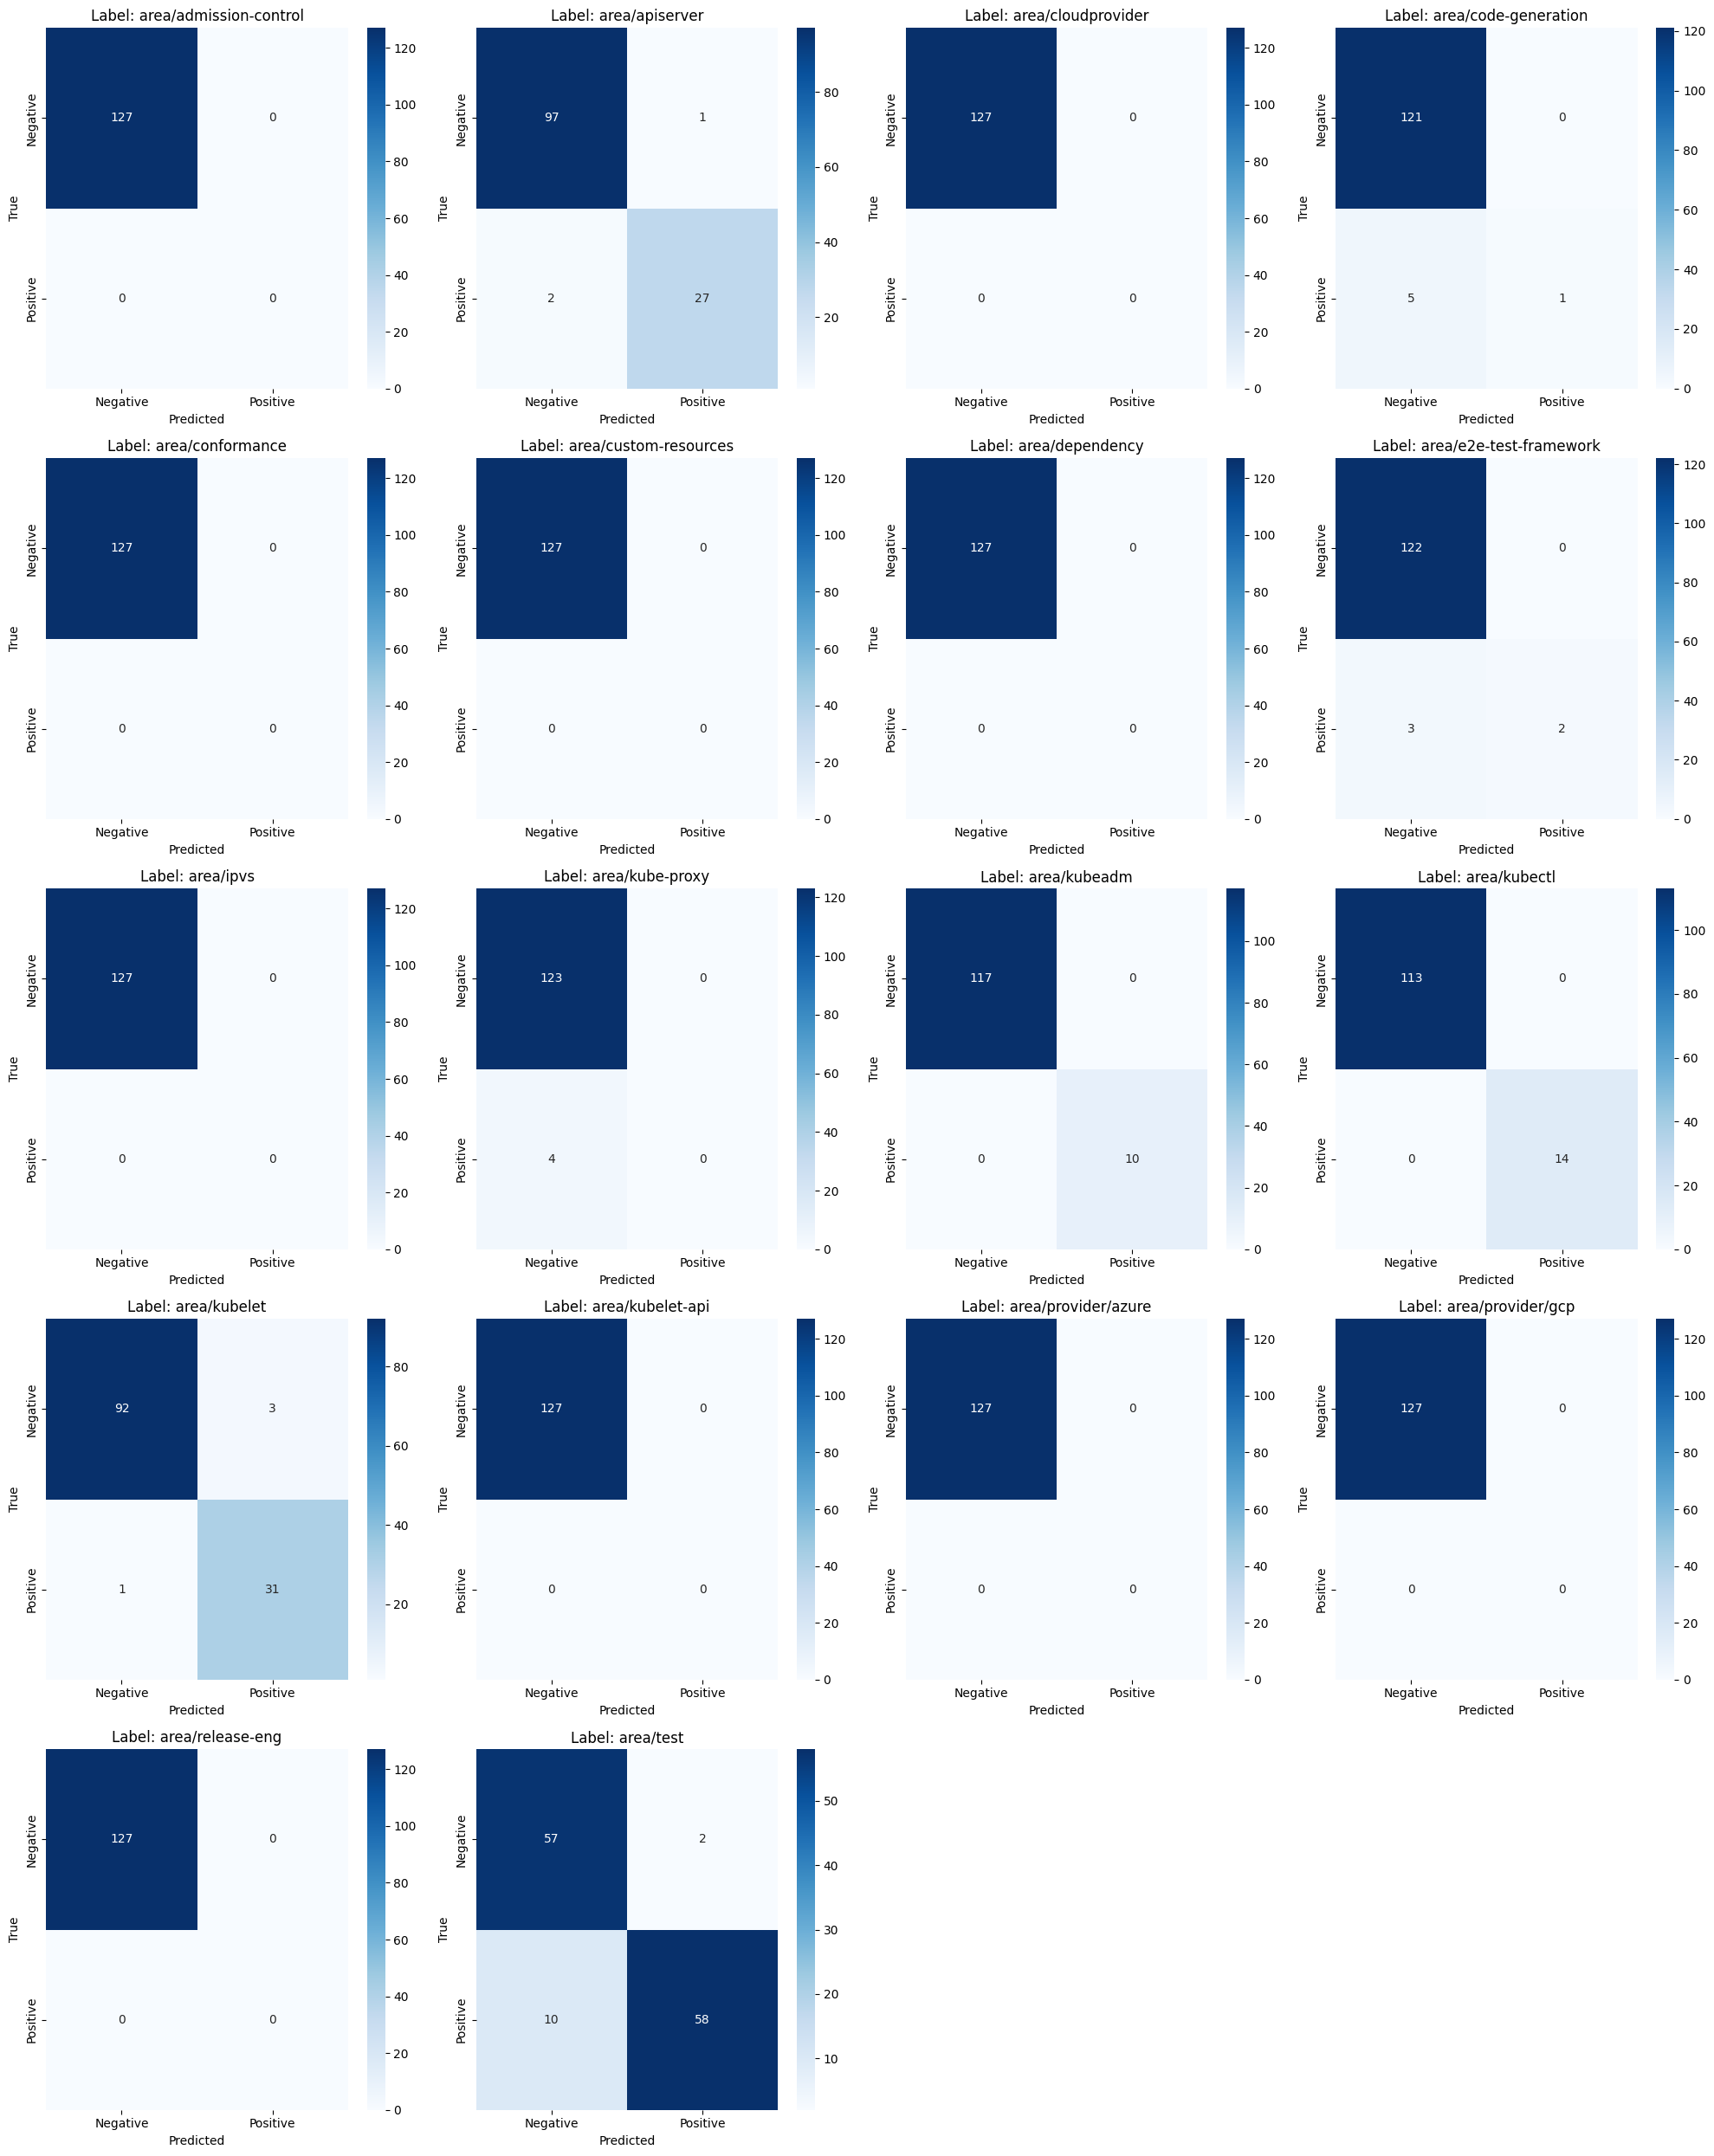

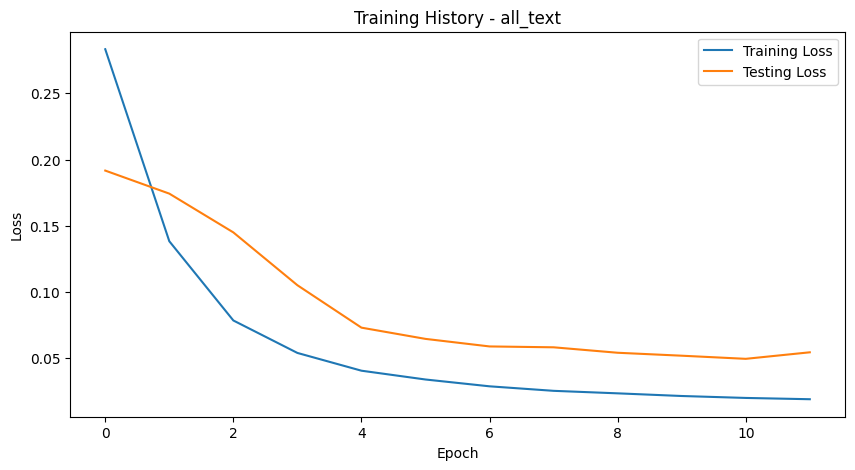

In [3]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=0,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', 
                        help='Enable predefined set of 15 labels instead of using all labels')
    parser.add_argument('--use_10_labels', action='store_true',
                        help='Enable predefined set of 10 specific labels instead of using all labels')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# FS 15 labels

max label length 5

Using 2 GPUs: [0, 1]
Loading tokenizer...
Loading training data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv...
Loading testing data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 4180/4180 [00:19<00:00, 211.05it/s]


Token length statistics before filtering:
  Mean: 355.03, Std Dev: 114.74
  Min: 23, Max: 1275
  25th percentile: 323.00
  50th percentile (median): 359.00
  75th percentile: 406.00
Applied 3.0 std dev threshold: (10.80, 699.26)
Removed 45 samples by std dev filtering (1.08% of data)
Total removed: 45 samples (1.08% of original data)
Remaining: 4135 samples (98.92% of original data)

Token length statistics after all filtering:
  Mean: 348.87, Std Dev: 96.97
  Min: 23, Max: 699
  25th percentile: 322.00
  50th percentile (median): 358.00
  75th percentile: 404.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 4135
Dataset size after basic cleaning: 4135 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 4135 (100.00% of data)

Step 5: Filtering infrequent label com

Calculating token lengths: 100%|██████████| 165/165 [00:00<00:00, 499.59it/s]


Token length statistics before filtering:
  Mean: 316.14, Std Dev: 259.63
  Min: 21, Max: 1305
  25th percentile: 132.00
  50th percentile (median): 218.00
  75th percentile: 402.00
Applied 3.0 std dev threshold: (1.00, 1095.03)
Removed 3 samples by std dev filtering (1.82% of data)
Total removed: 3 samples (1.82% of original data)
Remaining: 162 samples (98.18% of original data)

Token length statistics after all filtering:
  Mean: 298.48, Std Dev: 226.68
  Min: 21, Max: 859
  25th percentile: 132.00
  50th percentile (median): 208.50
  75th percentile: 385.25

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 162
Dataset size after basic cleaning: 162 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 13
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 13 (100.00% of labels)
Samples remaining after label filtering: 162 (100.00% of data)

Step 5: Filtering infrequent label combinat

Calculating token lengths: 100%|██████████| 149/149 [00:00<00:00, 561.06it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 699
  Mean token length: 348.51
  Median token length: 358.00
Testing set:
  Maximum token length: 859
  Mean token length: 294.36
  Median token length: 208.00
Encoding labels...
Training set label density: 0.0587
Average labels per sample: 1.06
Using predefined labels: True

Using predefined list of 15 labels...
Using 15 predefined labels: ['area/e2e-test-framework' 'area/apiserver' 'area/kubeadm'
 'area/cloudprovider' 'area/test' 'area/kubectl' 'area/kubelet'
 'area/code-generation' 'area/provider/azure' 'area/kubelet-api'
 'area/ipvs' 'area/kube-proxy' 'area/dependency' 'area/conformance'
 'area/provider/gcp']
Removing samples with no labels after filtering:
  Training: 719 samples removed (17.53% of data)
  Testing: 0 samples removed (0.00% of data)
After removing samples with no labels:
  Training samples: 3383
  Testing samples: 149
Training with 15 selected labels: ['area/e2e-test-framework' 'area/apiserver' 'a

Training: 100%|██████████| 106/106 [02:31<00:00,  1.43s/it]


Train Loss: 0.3226, Train Accuracy (Exact Match): 0.0030
Test Loss: 0.2716
Test Accuracy (Exact Match): 0.0940
Test Accuracy (Partial Match): 0.1792
Test Accuracy (Jaccard): 0.1792
Test Precision: 0.2886, Test Recall: 0.1792, Test F1: 0.2110
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 2/20


Training: 100%|██████████| 106/106 [02:34<00:00,  1.45s/it]


Train Loss: 0.1844, Train Accuracy (Exact Match): 0.1567
Test Loss: 0.2427
Test Accuracy (Exact Match): 0.1678
Test Accuracy (Partial Match): 0.2726
Test Accuracy (Jaccard): 0.2726
Test Precision: 0.4161, Test Recall: 0.2726, Test F1: 0.3130
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 3/20


Training: 100%|██████████| 106/106 [02:35<00:00,  1.47s/it]


Train Loss: 0.1032, Train Accuracy (Exact Match): 0.6385
Test Loss: 0.2164
Test Accuracy (Exact Match): 0.2215
Test Accuracy (Partial Match): 0.3744
Test Accuracy (Jaccard): 0.3710
Test Precision: 0.5604, Test Recall: 0.3744, Test F1: 0.4271
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 4/20


Training: 100%|██████████| 106/106 [02:42<00:00,  1.53s/it]


Train Loss: 0.0713, Train Accuracy (Exact Match): 0.7886
Test Loss: 0.1798
Test Accuracy (Exact Match): 0.4362
Test Accuracy (Partial Match): 0.5944
Test Accuracy (Jaccard): 0.5911
Test Precision: 0.7819, Test Recall: 0.5944, Test F1: 0.6483
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 5/20


Training: 100%|██████████| 106/106 [02:47<00:00,  1.58s/it]


Train Loss: 0.0538, Train Accuracy (Exact Match): 0.8469
Test Loss: 0.1550
Test Accuracy (Exact Match): 0.5503
Test Accuracy (Partial Match): 0.6794
Test Accuracy (Jaccard): 0.6794
Test Precision: 0.8523, Test Recall: 0.6794, Test F1: 0.7282
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 6/20


Training: 100%|██████████| 106/106 [02:47<00:00,  1.58s/it]


Train Loss: 0.0450, Train Accuracy (Exact Match): 0.8637
Test Loss: 0.1332
Test Accuracy (Exact Match): 0.6644
Test Accuracy (Partial Match): 0.7700
Test Accuracy (Jaccard): 0.7667
Test Precision: 0.8960, Test Recall: 0.7700, Test F1: 0.8036
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 7/20


Training: 100%|██████████| 106/106 [02:47<00:00,  1.58s/it]


Train Loss: 0.0387, Train Accuracy (Exact Match): 0.8664
Test Loss: 0.1243
Test Accuracy (Exact Match): 0.6913
Test Accuracy (Partial Match): 0.8122
Test Accuracy (Jaccard): 0.8044
Test Precision: 0.9161, Test Recall: 0.8122, Test F1: 0.8419
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 8/20


Training: 100%|██████████| 106/106 [02:47<00:00,  1.58s/it]


Train Loss: 0.0344, Train Accuracy (Exact Match): 0.8735
Test Loss: 0.1121
Test Accuracy (Exact Match): 0.6913
Test Accuracy (Partial Match): 0.8066
Test Accuracy (Jaccard): 0.7988
Test Precision: 0.9094, Test Recall: 0.8066, Test F1: 0.8344

Epoch 9/20


Training: 100%|██████████| 106/106 [02:47<00:00,  1.58s/it]


Train Loss: 0.0307, Train Accuracy (Exact Match): 0.8886
Test Loss: 0.1107
Test Accuracy (Exact Match): 0.7047
Test Accuracy (Partial Match): 0.8214
Test Accuracy (Jaccard): 0.8135
Test Precision: 0.9094, Test Recall: 0.8214, Test F1: 0.8473
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 10/20


Training: 100%|██████████| 106/106 [02:38<00:00,  1.50s/it]


Train Loss: 0.0284, Train Accuracy (Exact Match): 0.8871
Test Loss: 0.1092
Test Accuracy (Exact Match): 0.7047
Test Accuracy (Partial Match): 0.8326
Test Accuracy (Jaccard): 0.8219
Test Precision: 0.9178, Test Recall: 0.8326, Test F1: 0.8575
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 11/20


Training: 100%|██████████| 106/106 [02:37<00:00,  1.48s/it]


Train Loss: 0.0263, Train Accuracy (Exact Match): 0.8977
Test Loss: 0.1126
Test Accuracy (Exact Match): 0.6711
Test Accuracy (Partial Match): 0.8018
Test Accuracy (Jaccard): 0.7917
Test Precision: 0.8937, Test Recall: 0.8018, Test F1: 0.8284

Epoch 12/20


Training: 100%|██████████| 106/106 [02:36<00:00,  1.47s/it]


Train Loss: 0.0251, Train Accuracy (Exact Match): 0.8974
Test Loss: 0.1140
Test Accuracy (Exact Match): 0.6846
Test Accuracy (Partial Match): 0.8111
Test Accuracy (Jaccard): 0.7993
Test Precision: 0.9055, Test Recall: 0.8111, Test F1: 0.8364

Epoch 13/20


Training: 100%|██████████| 106/106 [02:35<00:00,  1.47s/it]


Train Loss: 0.0236, Train Accuracy (Exact Match): 0.8998
Test Loss: 0.1086
Test Accuracy (Exact Match): 0.6779
Test Accuracy (Partial Match): 0.8337
Test Accuracy (Jaccard): 0.8096
Test Precision: 0.9066, Test Recall: 0.8337, Test F1: 0.8494

Epoch 14/20


Training: 100%|██████████| 106/106 [02:36<00:00,  1.48s/it]


Train Loss: 0.0223, Train Accuracy (Exact Match): 0.9072
Test Loss: 0.1023
Test Accuracy (Exact Match): 0.7181
Test Accuracy (Partial Match): 0.8588
Test Accuracy (Jaccard): 0.8353
Test Precision: 0.9161, Test Recall: 0.8588, Test F1: 0.8693
Saved new best model to ./results/run_20250506_193810_all_text/best_model_all_text.pt

Epoch 15/20


Training: 100%|██████████| 106/106 [02:35<00:00,  1.46s/it]


Early stopping triggered
Train Loss: 0.0210, Train Accuracy (Exact Match): 0.9122
Test Loss: 0.1067
Test Accuracy (Exact Match): 0.6913
Test Accuracy (Partial Match): 0.8370
Test Accuracy (Jaccard): 0.8163
Test Precision: 0.9100, Test Recall: 0.8370, Test F1: 0.8539
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_19/2624682429.py:1403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.7181
Partial Match Accuracy: 0.8588
Jaccard Similarity: 0.8353
Precision: 0.9161
Recall: 0.8588
F1 Score: 0.8693

Training completed! Results saved to ./results/run_20250506_193810_all_text


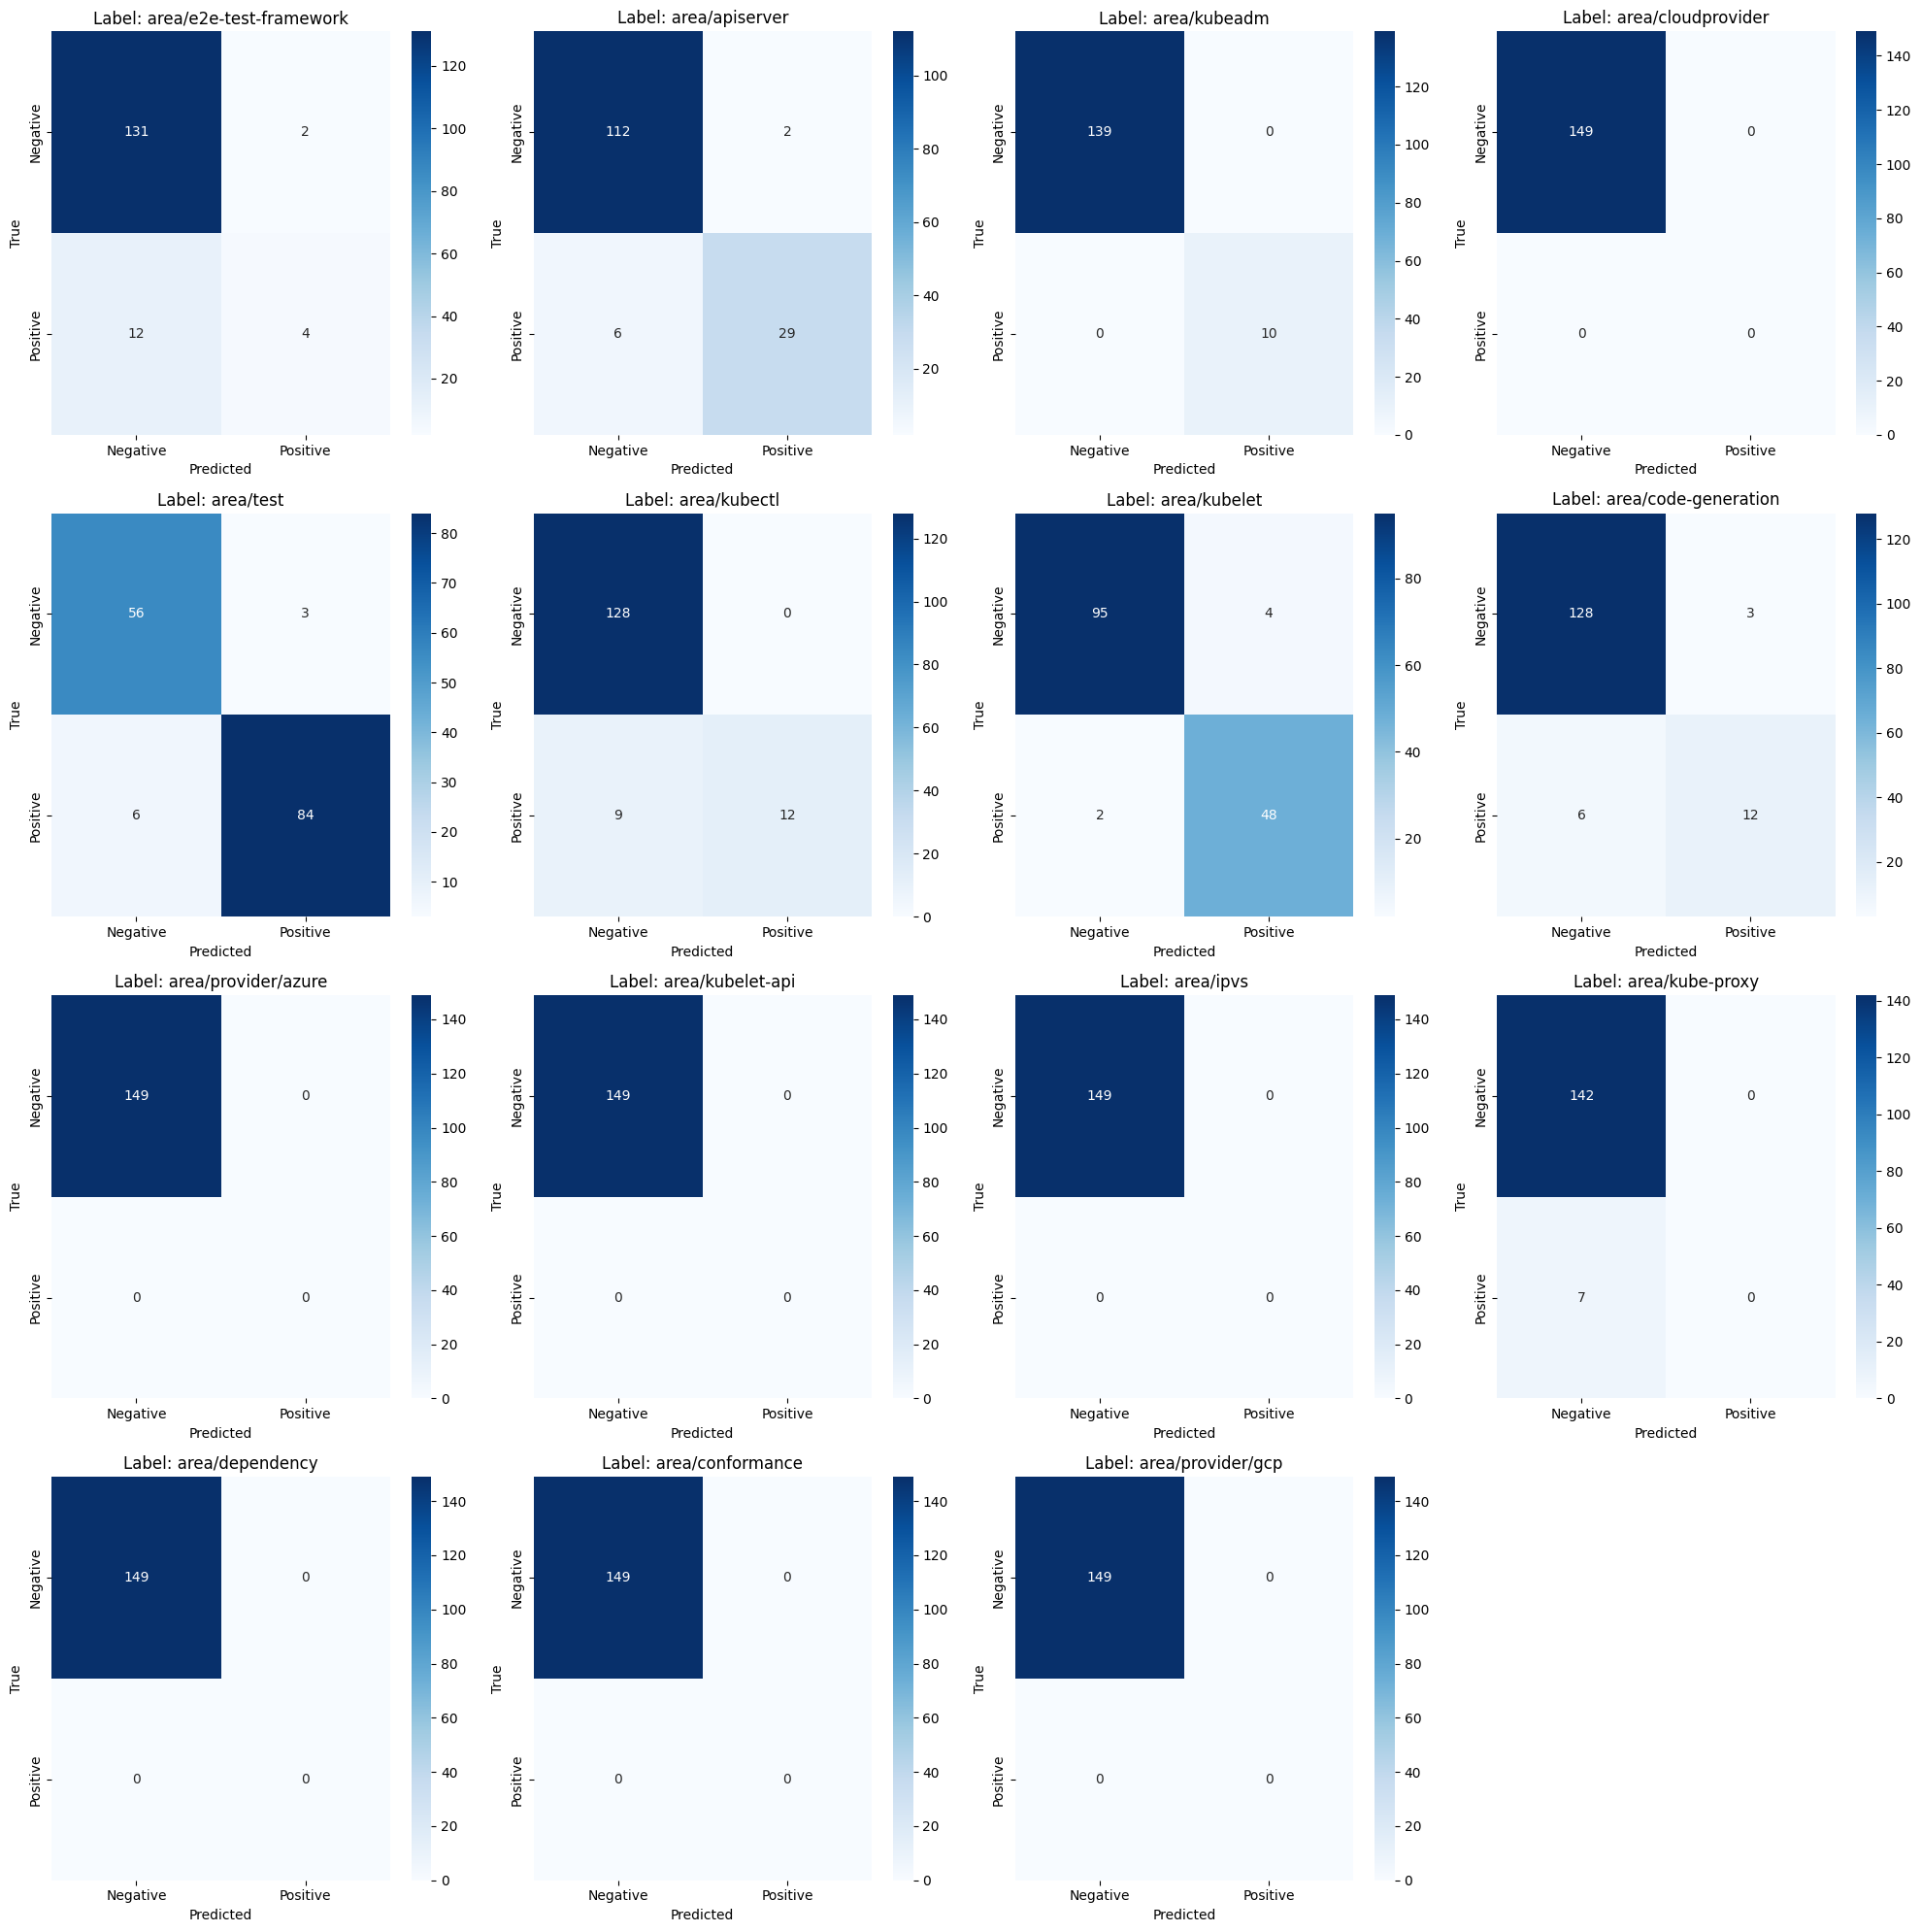

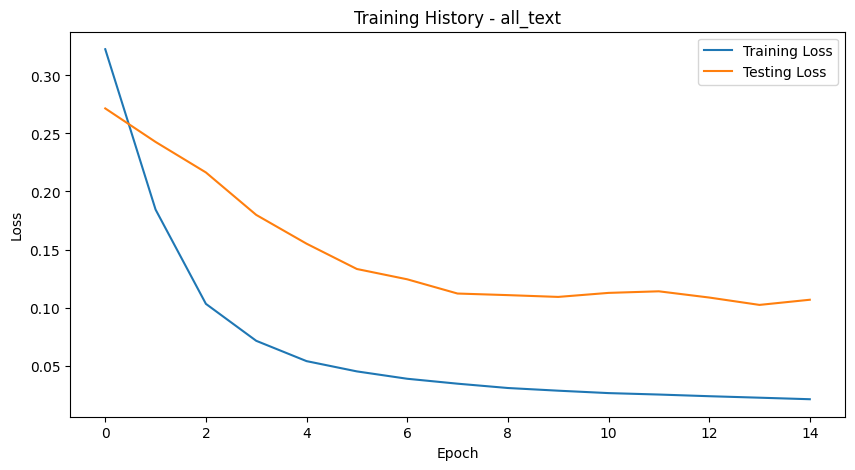

In [4]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=0,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', default=True,
                        help='Enable predefined set of 15 labels instead of using all labels')
    parser.add_argument('--use_10_labels', action='store_true',
                        help='Enable predefined set of 10 specific labels instead of using all labels')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

max label length 2

Using 2 GPUs: [0, 1]
Loading tokenizer...
Loading training data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv...
Loading testing data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 4180/4180 [00:20<00:00, 207.12it/s]


Token length statistics before filtering:
  Mean: 355.03, Std Dev: 114.74
  Min: 23, Max: 1275
  25th percentile: 323.00
  50th percentile (median): 359.00
  75th percentile: 406.00
Applied 3.0 std dev threshold: (10.80, 699.26)
Removed 45 samples by std dev filtering (1.08% of data)
Total removed: 45 samples (1.08% of original data)
Remaining: 4135 samples (98.92% of original data)

Token length statistics after all filtering:
  Mean: 348.87, Std Dev: 96.97
  Min: 23, Max: 699
  25th percentile: 322.00
  50th percentile (median): 358.00
  75th percentile: 404.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 4135
Dataset size after basic cleaning: 4135 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 4135 (100.00% of data)

Step 5: Filtering infrequent label com

Calculating token lengths: 100%|██████████| 165/165 [00:00<00:00, 485.80it/s]


Token length statistics before filtering:
  Mean: 316.14, Std Dev: 259.63
  Min: 21, Max: 1305
  25th percentile: 132.00
  50th percentile (median): 218.00
  75th percentile: 402.00
Applied 3.0 std dev threshold: (1.00, 1095.03)
Removed 3 samples by std dev filtering (1.82% of data)
Total removed: 3 samples (1.82% of original data)
Remaining: 162 samples (98.18% of original data)

Token length statistics after all filtering:
  Mean: 298.48, Std Dev: 226.68
  Min: 21, Max: 859
  25th percentile: 132.00
  50th percentile (median): 208.50
  75th percentile: 385.25

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 162
Dataset size after basic cleaning: 162 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 13
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 13 (100.00% of labels)
Samples remaining after label filtering: 162 (100.00% of data)

Step 5: Filtering infrequent label combinat

Calculating token lengths: 100%|██████████| 127/127 [00:00<00:00, 652.74it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 699
  Mean token length: 348.18
  Median token length: 358.00
Testing set:
  Maximum token length: 823
  Mean token length: 247.41
  Median token length: 190.00
Encoding labels...
Training set label density: 0.0578
Average labels per sample: 1.04
Using predefined labels: True

Using predefined list of 15 labels...
Using 15 predefined labels: ['area/e2e-test-framework' 'area/apiserver' 'area/kubeadm'
 'area/cloudprovider' 'area/test' 'area/kubectl' 'area/kubelet'
 'area/code-generation' 'area/provider/azure' 'area/kubelet-api'
 'area/ipvs' 'area/kube-proxy' 'area/dependency' 'area/conformance'
 'area/provider/gcp']
Removing samples with no labels after filtering:
  Training: 719 samples removed (17.66% of data)
  Testing: 0 samples removed (0.00% of data)
After removing samples with no labels:
  Training samples: 3352
  Testing samples: 127
Training with 15 selected labels: ['area/e2e-test-framework' 'area/apiserver' 'a

Training: 100%|██████████| 105/105 [02:31<00:00,  1.44s/it]


Train Loss: 0.3272, Train Accuracy (Exact Match): 0.0015
Test Loss: 0.2238
Test Accuracy (Exact Match): 0.1181
Test Accuracy (Partial Match): 0.1890
Test Accuracy (Jaccard): 0.1890
Test Precision: 0.2598, Test Recall: 0.1890, Test F1: 0.2126
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 2/20


Training: 100%|██████████| 105/105 [02:35<00:00,  1.48s/it]


Train Loss: 0.1817, Train Accuracy (Exact Match): 0.1533
Test Loss: 0.2036
Test Accuracy (Exact Match): 0.1732
Test Accuracy (Partial Match): 0.2638
Test Accuracy (Jaccard): 0.2638
Test Precision: 0.3543, Test Recall: 0.2638, Test F1: 0.2940
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 3/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.1011, Train Accuracy (Exact Match): 0.6277
Test Loss: 0.1638
Test Accuracy (Exact Match): 0.2441
Test Accuracy (Partial Match): 0.3701
Test Accuracy (Jaccard): 0.3701
Test Precision: 0.4961, Test Recall: 0.3701, Test F1: 0.4121
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 4/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.0689, Train Accuracy (Exact Match): 0.7900
Test Loss: 0.1326
Test Accuracy (Exact Match): 0.4724
Test Accuracy (Partial Match): 0.6260
Test Accuracy (Jaccard): 0.6129
Test Precision: 0.7402, Test Recall: 0.6260, Test F1: 0.6601
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 5/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.0521, Train Accuracy (Exact Match): 0.8455
Test Loss: 0.1014
Test Accuracy (Exact Match): 0.6063
Test Accuracy (Partial Match): 0.7323
Test Accuracy (Jaccard): 0.7283
Test Precision: 0.8465, Test Recall: 0.7323, Test F1: 0.7690
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 6/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.0421, Train Accuracy (Exact Match): 0.8690
Test Loss: 0.0849
Test Accuracy (Exact Match): 0.7402
Test Accuracy (Partial Match): 0.8071
Test Accuracy (Jaccard): 0.8071
Test Precision: 0.8740, Test Recall: 0.8071, Test F1: 0.8294
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 7/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.0360, Train Accuracy (Exact Match): 0.8798
Test Loss: 0.0760
Test Accuracy (Exact Match): 0.7874
Test Accuracy (Partial Match): 0.8465
Test Accuracy (Jaccard): 0.8412
Test Precision: 0.8898, Test Recall: 0.8465, Test F1: 0.8596
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 8/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.0326, Train Accuracy (Exact Match): 0.8875
Test Loss: 0.0724
Test Accuracy (Exact Match): 0.7795
Test Accuracy (Partial Match): 0.8425
Test Accuracy (Jaccard): 0.8346
Test Precision: 0.8819, Test Recall: 0.8425, Test F1: 0.8530

Epoch 9/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.0294, Train Accuracy (Exact Match): 0.8917
Test Loss: 0.0665
Test Accuracy (Exact Match): 0.8110
Test Accuracy (Partial Match): 0.8622
Test Accuracy (Jaccard): 0.8570
Test Precision: 0.8976, Test Recall: 0.8622, Test F1: 0.8727
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt

Epoch 10/20


Training: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


Train Loss: 0.0268, Train Accuracy (Exact Match): 0.8965
Test Loss: 0.0675
Test Accuracy (Exact Match): 0.8110
Test Accuracy (Partial Match): 0.8583
Test Accuracy (Jaccard): 0.8530
Test Precision: 0.8898, Test Recall: 0.8583, Test F1: 0.8675

Epoch 11/20


Training: 100%|██████████| 105/105 [02:44<00:00,  1.57s/it]


Train Loss: 0.0260, Train Accuracy (Exact Match): 0.9027
Test Loss: 0.0720
Test Accuracy (Exact Match): 0.7638
Test Accuracy (Partial Match): 0.8425
Test Accuracy (Jaccard): 0.8294
Test Precision: 0.8819, Test Recall: 0.8425, Test F1: 0.8517

Epoch 12/20


Training: 100%|██████████| 105/105 [02:45<00:00,  1.57s/it]


Train Loss: 0.0238, Train Accuracy (Exact Match): 0.9024
Test Loss: 0.0645
Test Accuracy (Exact Match): 0.7874
Test Accuracy (Partial Match): 0.8701
Test Accuracy (Jaccard): 0.8491
Test Precision: 0.8898, Test Recall: 0.8701, Test F1: 0.8701

Epoch 13/20


Training: 100%|██████████| 105/105 [02:45<00:00,  1.58s/it]


Train Loss: 0.0218, Train Accuracy (Exact Match): 0.9096
Test Loss: 0.0632
Test Accuracy (Exact Match): 0.7795
Test Accuracy (Partial Match): 0.8504
Test Accuracy (Jaccard): 0.8373
Test Precision: 0.8819, Test Recall: 0.8504, Test F1: 0.8570

Epoch 14/20


Training: 100%|██████████| 105/105 [02:46<00:00,  1.58s/it]


Early stopping triggered
Train Loss: 0.0206, Train Accuracy (Exact Match): 0.9129
Test Loss: 0.0611
Test Accuracy (Exact Match): 0.8189
Test Accuracy (Partial Match): 0.8780
Test Accuracy (Jaccard): 0.8648
Test Precision: 0.8976, Test Recall: 0.8780, Test F1: 0.8806
Saved new best model to ./results/run_20250506_202024_all_text/best_model_all_text.pt
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_19/2624682429.py:1403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.8189
Partial Match Accuracy: 0.8780
Jaccard Similarity: 0.8648
Precision: 0.8976
Recall: 0.8780
F1 Score: 0.8806

Training completed! Results saved to ./results/run_20250506_202024_all_text


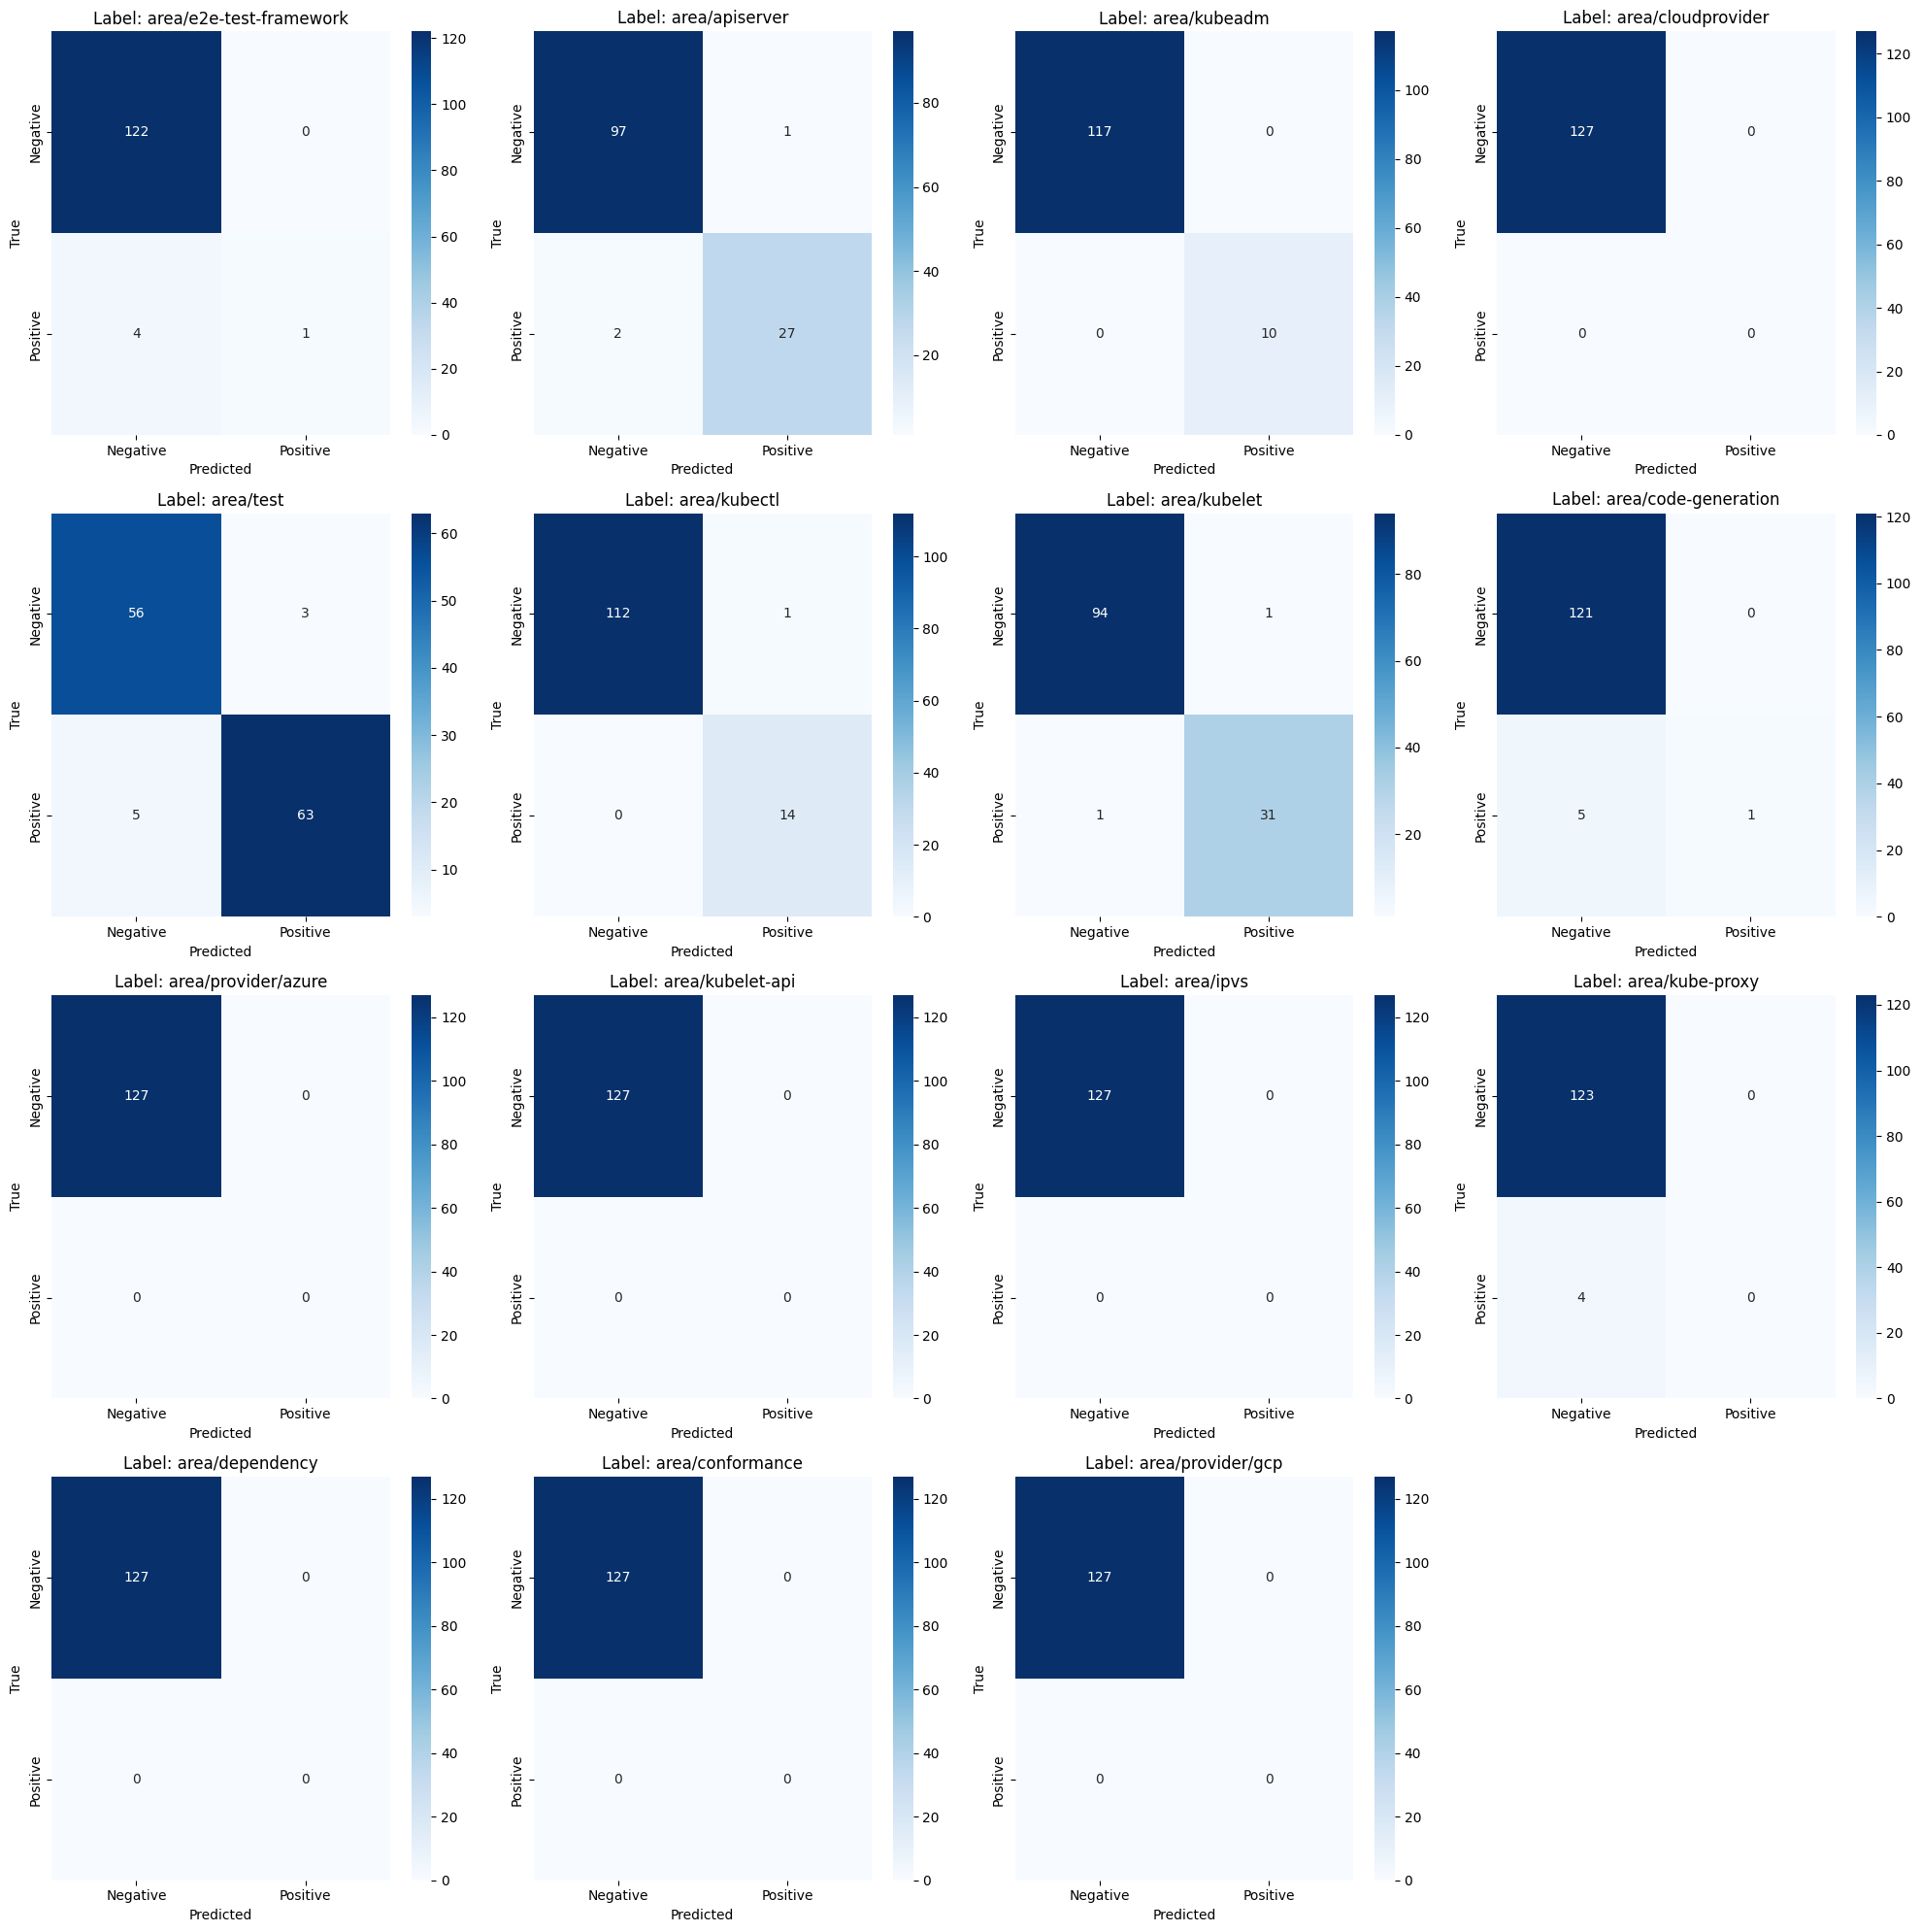

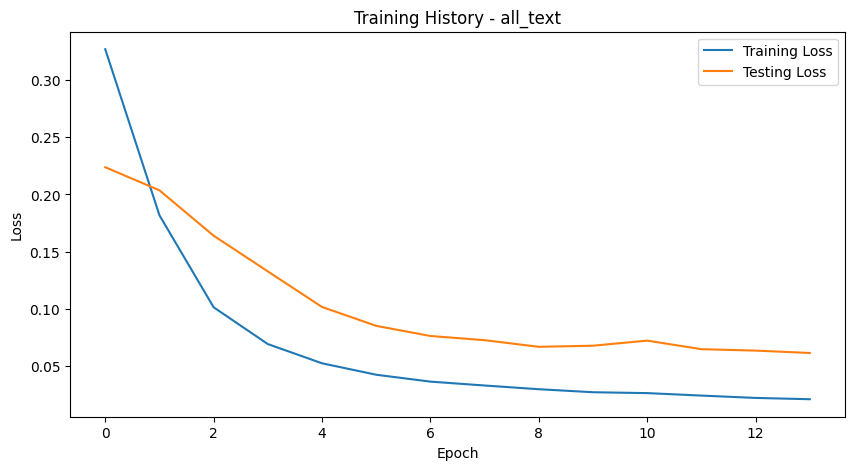

In [5]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=0,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', default=True,
                        help='Enable predefined set of 15 labels instead of using all labels')
    parser.add_argument('--use_10_labels', action='store_true',
                        help='Enable predefined set of 10 specific labels instead of using all labels')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# FS 10 labels

max labels length 5

Using 2 GPUs: [0, 1]
Loading tokenizer...
Loading training data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv...
Loading testing data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 4180/4180 [00:19<00:00, 210.51it/s]


Token length statistics before filtering:
  Mean: 355.03, Std Dev: 114.74
  Min: 23, Max: 1275
  25th percentile: 323.00
  50th percentile (median): 359.00
  75th percentile: 406.00
Applied 3.0 std dev threshold: (10.80, 699.26)
Removed 45 samples by std dev filtering (1.08% of data)
Total removed: 45 samples (1.08% of original data)
Remaining: 4135 samples (98.92% of original data)

Token length statistics after all filtering:
  Mean: 348.87, Std Dev: 96.97
  Min: 23, Max: 699
  25th percentile: 322.00
  50th percentile (median): 358.00
  75th percentile: 404.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 4135
Dataset size after basic cleaning: 4135 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 4135 (100.00% of data)

Step 5: Filtering infrequent label com

Calculating token lengths: 100%|██████████| 165/165 [00:00<00:00, 487.77it/s]


Token length statistics before filtering:
  Mean: 316.14, Std Dev: 259.63
  Min: 21, Max: 1305
  25th percentile: 132.00
  50th percentile (median): 218.00
  75th percentile: 402.00
Applied 3.0 std dev threshold: (1.00, 1095.03)
Removed 3 samples by std dev filtering (1.82% of data)
Total removed: 3 samples (1.82% of original data)
Remaining: 162 samples (98.18% of original data)

Token length statistics after all filtering:
  Mean: 298.48, Std Dev: 226.68
  Min: 21, Max: 859
  25th percentile: 132.00
  50th percentile (median): 208.50
  75th percentile: 385.25

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 162
Dataset size after basic cleaning: 162 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 13
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 13 (100.00% of labels)
Samples remaining after label filtering: 162 (100.00% of data)

Step 5: Filtering infrequent label combinat

Calculating token lengths: 100%|██████████| 149/149 [00:00<00:00, 582.61it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 699
  Mean token length: 348.51
  Median token length: 358.00
Testing set:
  Maximum token length: 859
  Mean token length: 294.36
  Median token length: 208.00
Encoding labels...
Training set label density: 0.0587
Average labels per sample: 1.06
Using predefined labels: True

Using predefined list of 10 labels...
Using 10 selected labels: ['area/e2e-test-framework' 'area/apiserver' 'area/kubeadm'
 'area/cloudprovider' 'area/test' 'area/kubectl' 'area/kubelet'
 'area/code-generation' 'area/provider/azure' 'area/kubelet-api']
Removing samples with no labels after filtering:
  Training: 1887 samples removed (46.00% of data)
  Testing: 4 samples removed (2.68% of data)
After removing samples with no labels:
  Training samples: 2215
  Testing samples: 145
Training with 10 selected labels: ['area/e2e-test-framework' 'area/apiserver' 'area/kubeadm'
 'area/cloudprovider' 'area/test' 'area/kubectl' 'area/kubelet'
 'area/code-g

Training: 100%|██████████| 70/70 [01:49<00:00,  1.57s/it]


Train Loss: 0.4160, Train Accuracy (Exact Match): 0.0023
Test Loss: 0.3762
Test Accuracy (Exact Match): 0.1379
Test Accuracy (Partial Match): 0.2445
Test Accuracy (Jaccard): 0.2445
Test Precision: 0.3724, Test Recall: 0.2445, Test F1: 0.2828
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 2/20


Training: 100%|██████████| 70/70 [01:49<00:00,  1.56s/it]


Train Loss: 0.2466, Train Accuracy (Exact Match): 0.1959
Test Loss: 0.3253
Test Accuracy (Exact Match): 0.1724
Test Accuracy (Partial Match): 0.3129
Test Accuracy (Jaccard): 0.3129
Test Precision: 0.4966, Test Recall: 0.3129, Test F1: 0.3657
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 3/20


Training: 100%|██████████| 70/70 [01:43<00:00,  1.48s/it]


Train Loss: 0.1387, Train Accuracy (Exact Match): 0.6379
Test Loss: 0.2806
Test Accuracy (Exact Match): 0.2690
Test Accuracy (Partial Match): 0.4405
Test Accuracy (Jaccard): 0.4370
Test Precision: 0.6448, Test Recall: 0.4405, Test F1: 0.4991
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 4/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


Train Loss: 0.0892, Train Accuracy (Exact Match): 0.8181
Test Loss: 0.2196
Test Accuracy (Exact Match): 0.5448
Test Accuracy (Partial Match): 0.7068
Test Accuracy (Jaccard): 0.6926
Test Precision: 0.8655, Test Recall: 0.7068, Test F1: 0.7478
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 5/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Train Loss: 0.0646, Train Accuracy (Exact Match): 0.8709
Test Loss: 0.1912
Test Accuracy (Exact Match): 0.6138
Test Accuracy (Partial Match): 0.7422
Test Accuracy (Jaccard): 0.7387
Test Precision: 0.8655, Test Recall: 0.7422, Test F1: 0.7800
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 6/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Train Loss: 0.0527, Train Accuracy (Exact Match): 0.8871
Test Loss: 0.1684
Test Accuracy (Exact Match): 0.7172
Test Accuracy (Partial Match): 0.8263
Test Accuracy (Jaccard): 0.8148
Test Precision: 0.9310, Test Recall: 0.8263, Test F1: 0.8510
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 7/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Train Loss: 0.0452, Train Accuracy (Exact Match): 0.8971
Test Loss: 0.1534
Test Accuracy (Exact Match): 0.7517
Test Accuracy (Partial Match): 0.8459
Test Accuracy (Jaccard): 0.8390
Test Precision: 0.9517, Test Recall: 0.8459, Test F1: 0.8720
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 8/20


Training: 100%|██████████| 70/70 [01:41<00:00,  1.46s/it]


Train Loss: 0.0414, Train Accuracy (Exact Match): 0.9038
Test Loss: 0.1491
Test Accuracy (Exact Match): 0.7517
Test Accuracy (Partial Match): 0.8407
Test Accuracy (Jaccard): 0.8372
Test Precision: 0.9483, Test Recall: 0.8407, Test F1: 0.8687

Epoch 9/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Train Loss: 0.0364, Train Accuracy (Exact Match): 0.9147
Test Loss: 0.1268
Test Accuracy (Exact Match): 0.7517
Test Accuracy (Partial Match): 0.8774
Test Accuracy (Jaccard): 0.8578
Test Precision: 0.9437, Test Recall: 0.8774, Test F1: 0.8918
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 10/20


Training: 100%|██████████| 70/70 [01:41<00:00,  1.46s/it]


Train Loss: 0.0329, Train Accuracy (Exact Match): 0.9183
Test Loss: 0.1345
Test Accuracy (Exact Match): 0.7379
Test Accuracy (Partial Match): 0.8774
Test Accuracy (Jaccard): 0.8538
Test Precision: 0.9397, Test Recall: 0.8774, Test F1: 0.8894

Epoch 11/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Train Loss: 0.0310, Train Accuracy (Exact Match): 0.9260
Test Loss: 0.1267
Test Accuracy (Exact Match): 0.7655
Test Accuracy (Partial Match): 0.8866
Test Accuracy (Jaccard): 0.8687
Test Precision: 0.9454, Test Recall: 0.8866, Test F1: 0.8998
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 12/20


Training: 100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


Train Loss: 0.0294, Train Accuracy (Exact Match): 0.9228
Test Loss: 0.1420
Test Accuracy (Exact Match): 0.7586
Test Accuracy (Partial Match): 0.8587
Test Accuracy (Jaccard): 0.8490
Test Precision: 0.9443, Test Recall: 0.8587, Test F1: 0.8801

Epoch 13/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Train Loss: 0.0278, Train Accuracy (Exact Match): 0.9291
Test Loss: 0.1416
Test Accuracy (Exact Match): 0.7586
Test Accuracy (Partial Match): 0.8760
Test Accuracy (Jaccard): 0.8616
Test Precision: 0.9489, Test Recall: 0.8760, Test F1: 0.8942

Epoch 14/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Train Loss: 0.0255, Train Accuracy (Exact Match): 0.9336
Test Loss: 0.1447
Test Accuracy (Exact Match): 0.7310
Test Accuracy (Partial Match): 0.8636
Test Accuracy (Jaccard): 0.8411
Test Precision: 0.9247, Test Recall: 0.8636, Test F1: 0.8758

Epoch 15/20


Training: 100%|██████████| 70/70 [01:41<00:00,  1.46s/it]


Train Loss: 0.0247, Train Accuracy (Exact Match): 0.9350
Test Loss: 0.1425
Test Accuracy (Exact Match): 0.7655
Test Accuracy (Partial Match): 0.8860
Test Accuracy (Jaccard): 0.8682
Test Precision: 0.9523, Test Recall: 0.8860, Test F1: 0.9010
Saved new best model to ./results/run_20250506_205922_all_text/best_model_all_text.pt

Epoch 16/20


Training: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


Early stopping triggered
Train Loss: 0.0241, Train Accuracy (Exact Match): 0.9354
Test Loss: 0.1500
Test Accuracy (Exact Match): 0.7448
Test Accuracy (Partial Match): 0.8706
Test Accuracy (Jaccard): 0.8539
Test Precision: 0.9466, Test Recall: 0.8706, Test F1: 0.8884
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_19/2624682429.py:1403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.7655
Partial Match Accuracy: 0.8860
Jaccard Similarity: 0.8682
Precision: 0.9523
Recall: 0.8860
F1 Score: 0.9010

Training completed! Results saved to ./results/run_20250506_205922_all_text


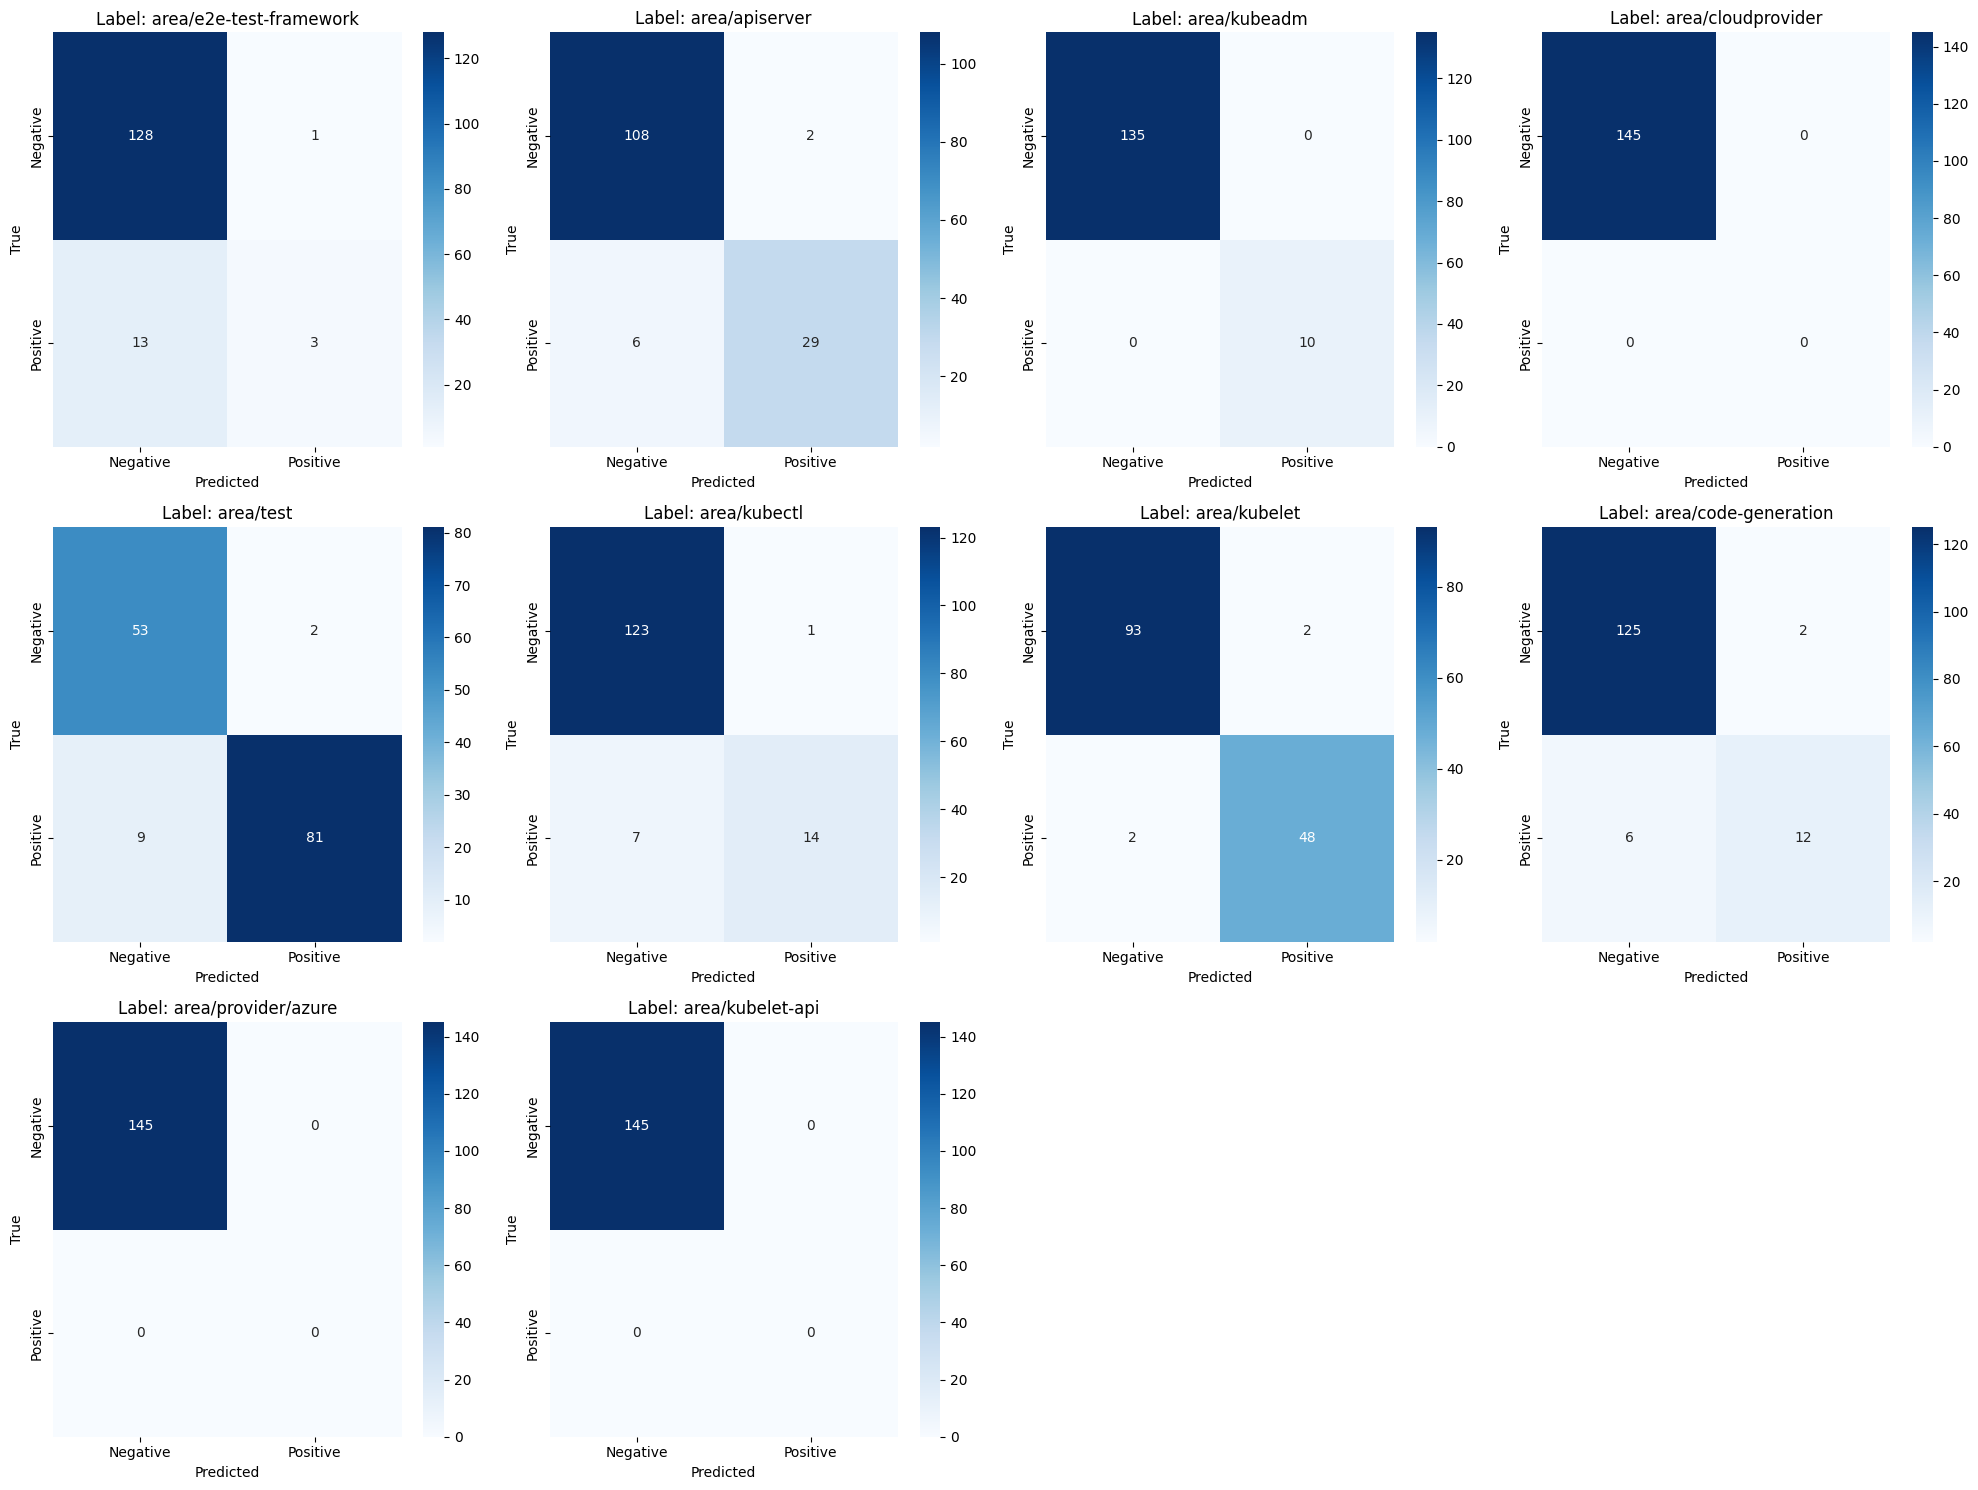

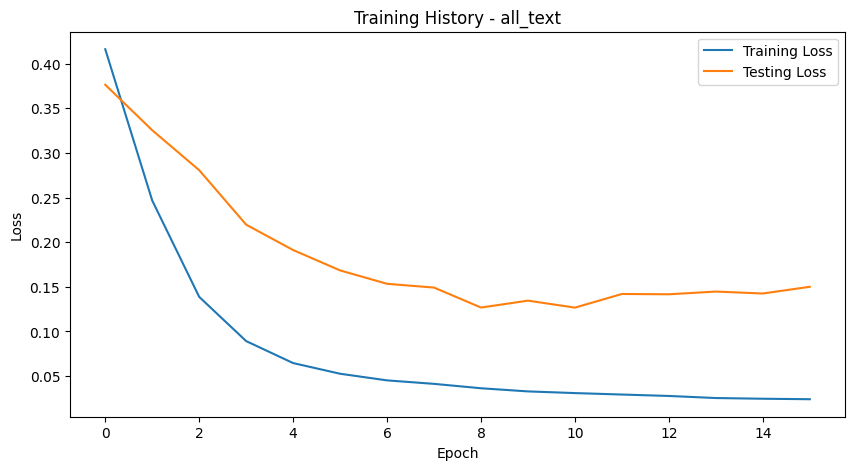

In [6]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=0,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', 
                        help='Enable predefined set of 15 labels instead of using all labels')
    parser.add_argument('--use_10_labels', action='store_true', default=True,
                        help='Enable predefined set of 10 specific labels instead of using all labels')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

max label length 2

Using 2 GPUs: [0, 1]
Loading tokenizer...
Loading training data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv...
Loading testing data from /kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 4180/4180 [00:20<00:00, 208.33it/s]


Token length statistics before filtering:
  Mean: 355.03, Std Dev: 114.74
  Min: 23, Max: 1275
  25th percentile: 323.00
  50th percentile (median): 359.00
  75th percentile: 406.00
Applied 3.0 std dev threshold: (10.80, 699.26)
Removed 45 samples by std dev filtering (1.08% of data)
Total removed: 45 samples (1.08% of original data)
Remaining: 4135 samples (98.92% of original data)

Token length statistics after all filtering:
  Mean: 348.87, Std Dev: 96.97
  Min: 23, Max: 699
  25th percentile: 322.00
  50th percentile (median): 358.00
  75th percentile: 404.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 4135
Dataset size after basic cleaning: 4135 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 4135 (100.00% of data)

Step 5: Filtering infrequent label com

Calculating token lengths: 100%|██████████| 165/165 [00:00<00:00, 502.46it/s]


Token length statistics before filtering:
  Mean: 316.14, Std Dev: 259.63
  Min: 21, Max: 1305
  25th percentile: 132.00
  50th percentile (median): 218.00
  75th percentile: 402.00
Applied 3.0 std dev threshold: (1.00, 1095.03)
Removed 3 samples by std dev filtering (1.82% of data)
Total removed: 3 samples (1.82% of original data)
Remaining: 162 samples (98.18% of original data)

Token length statistics after all filtering:
  Mean: 298.48, Std Dev: 226.68
  Min: 21, Max: 859
  25th percentile: 132.00
  50th percentile (median): 208.50
  75th percentile: 385.25

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 162
Dataset size after basic cleaning: 162 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 0)
Total unique labels before filtering: 13
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 13 (100.00% of labels)
Samples remaining after label filtering: 162 (100.00% of data)

Step 5: Filtering infrequent label combinat

Calculating token lengths: 100%|██████████| 127/127 [00:00<00:00, 669.97it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 699
  Mean token length: 348.18
  Median token length: 358.00
Testing set:
  Maximum token length: 823
  Mean token length: 247.41
  Median token length: 190.00
Encoding labels...
Training set label density: 0.0578
Average labels per sample: 1.04
Using predefined labels: True

Using predefined list of 10 labels...
Using 10 selected labels: ['area/e2e-test-framework' 'area/apiserver' 'area/kubeadm'
 'area/cloudprovider' 'area/test' 'area/kubectl' 'area/kubelet'
 'area/code-generation' 'area/provider/azure' 'area/kubelet-api']
Removing samples with no labels after filtering:
  Training: 1887 samples removed (46.35% of data)
  Testing: 4 samples removed (3.15% of data)
After removing samples with no labels:
  Training samples: 2184
  Testing samples: 123
Training with 10 selected labels: ['area/e2e-test-framework' 'area/apiserver' 'area/kubeadm'
 'area/cloudprovider' 'area/test' 'area/kubectl' 'area/kubelet'
 'area/code-g

Training: 100%|██████████| 69/69 [01:37<00:00,  1.42s/it]


Train Loss: 0.4159, Train Accuracy (Exact Match): 0.0037
Test Loss: 0.3138
Test Accuracy (Exact Match): 0.0407
Test Accuracy (Partial Match): 0.0569
Test Accuracy (Jaccard): 0.0569
Test Precision: 0.0732, Test Recall: 0.0569, Test F1: 0.0623
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 2/20


Training: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it]


Train Loss: 0.2391, Train Accuracy (Exact Match): 0.1983
Test Loss: 0.2718
Test Accuracy (Exact Match): 0.2114
Test Accuracy (Partial Match): 0.3333
Test Accuracy (Jaccard): 0.3333
Test Precision: 0.4553, Test Recall: 0.3333, Test F1: 0.3740
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 3/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it]


Train Loss: 0.1351, Train Accuracy (Exact Match): 0.6571
Test Loss: 0.2198
Test Accuracy (Exact Match): 0.2764
Test Accuracy (Partial Match): 0.4228
Test Accuracy (Jaccard): 0.4187
Test Precision: 0.5569, Test Recall: 0.4228, Test F1: 0.4661
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 4/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it]


Train Loss: 0.0874, Train Accuracy (Exact Match): 0.8077
Test Loss: 0.1520
Test Accuracy (Exact Match): 0.5528
Test Accuracy (Partial Match): 0.7317
Test Accuracy (Jaccard): 0.7114
Test Precision: 0.8496, Test Recall: 0.7317, Test F1: 0.7642
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 5/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it]


Train Loss: 0.0632, Train Accuracy (Exact Match): 0.8686
Test Loss: 0.1166
Test Accuracy (Exact Match): 0.7073
Test Accuracy (Partial Match): 0.8089
Test Accuracy (Jaccard): 0.8035
Test Precision: 0.8943, Test Recall: 0.8089, Test F1: 0.8360
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 6/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it]


Train Loss: 0.0493, Train Accuracy (Exact Match): 0.8951
Test Loss: 0.0956
Test Accuracy (Exact Match): 0.7154
Test Accuracy (Partial Match): 0.8171
Test Accuracy (Jaccard): 0.8130
Test Precision: 0.9065, Test Recall: 0.8171, Test F1: 0.8455
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 7/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it]


Train Loss: 0.0426, Train Accuracy (Exact Match): 0.9075
Test Loss: 0.0838
Test Accuracy (Exact Match): 0.8049
Test Accuracy (Partial Match): 0.8821
Test Accuracy (Jaccard): 0.8726
Test Precision: 0.9309, Test Recall: 0.8821, Test F1: 0.8957
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 8/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.48s/it]


Train Loss: 0.0379, Train Accuracy (Exact Match): 0.9139
Test Loss: 0.0803
Test Accuracy (Exact Match): 0.7967
Test Accuracy (Partial Match): 0.8699
Test Accuracy (Jaccard): 0.8645
Test Precision: 0.9268, Test Recall: 0.8699, Test F1: 0.8875

Epoch 9/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it]


Train Loss: 0.0347, Train Accuracy (Exact Match): 0.9245
Test Loss: 0.0751
Test Accuracy (Exact Match): 0.8455
Test Accuracy (Partial Match): 0.9065
Test Accuracy (Jaccard): 0.8970
Test Precision: 0.9390, Test Recall: 0.9065, Test F1: 0.9146
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 10/20


Training: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it]


Train Loss: 0.0308, Train Accuracy (Exact Match): 0.9341
Test Loss: 0.0712
Test Accuracy (Exact Match): 0.8293
Test Accuracy (Partial Match): 0.9065
Test Accuracy (Jaccard): 0.8889
Test Precision: 0.9309, Test Recall: 0.9065, Test F1: 0.9092

Epoch 11/20


Training: 100%|██████████| 69/69 [01:45<00:00,  1.52s/it]


Train Loss: 0.0289, Train Accuracy (Exact Match): 0.9267
Test Loss: 0.0702
Test Accuracy (Exact Match): 0.8374
Test Accuracy (Partial Match): 0.9024
Test Accuracy (Jaccard): 0.8930
Test Precision: 0.9390, Test Recall: 0.9024, Test F1: 0.9119

Epoch 12/20


Training: 100%|██████████| 69/69 [01:46<00:00,  1.55s/it]


Train Loss: 0.0280, Train Accuracy (Exact Match): 0.9332
Test Loss: 0.0695
Test Accuracy (Exact Match): 0.8455
Test Accuracy (Partial Match): 0.9065
Test Accuracy (Jaccard): 0.8957
Test Precision: 0.9350, Test Recall: 0.9065, Test F1: 0.9133

Epoch 13/20


Training: 100%|██████████| 69/69 [01:48<00:00,  1.57s/it]


Train Loss: 0.0261, Train Accuracy (Exact Match): 0.9359
Test Loss: 0.0674
Test Accuracy (Exact Match): 0.8537
Test Accuracy (Partial Match): 0.9024
Test Accuracy (Jaccard): 0.8970
Test Precision: 0.9350, Test Recall: 0.9024, Test F1: 0.9119

Epoch 14/20


Training: 100%|██████████| 69/69 [01:47<00:00,  1.55s/it]


Train Loss: 0.0237, Train Accuracy (Exact Match): 0.9382
Test Loss: 0.0681
Test Accuracy (Exact Match): 0.8374
Test Accuracy (Partial Match): 0.9024
Test Accuracy (Jaccard): 0.8930
Test Precision: 0.9390, Test Recall: 0.9024, Test F1: 0.9119

Epoch 15/20


Training: 100%|██████████| 69/69 [01:47<00:00,  1.56s/it]


Train Loss: 0.0240, Train Accuracy (Exact Match): 0.9437
Test Loss: 0.0710
Test Accuracy (Exact Match): 0.8374
Test Accuracy (Partial Match): 0.9106
Test Accuracy (Jaccard): 0.8970
Test Precision: 0.9431, Test Recall: 0.9106, Test F1: 0.9173
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 16/20


Training: 100%|██████████| 69/69 [01:47<00:00,  1.56s/it]


Train Loss: 0.0211, Train Accuracy (Exact Match): 0.9469
Test Loss: 0.0675
Test Accuracy (Exact Match): 0.8130
Test Accuracy (Partial Match): 0.8699
Test Accuracy (Jaccard): 0.8645
Test Precision: 0.9106, Test Recall: 0.8699, Test F1: 0.8821

Epoch 17/20


Training: 100%|██████████| 69/69 [01:47<00:00,  1.56s/it]


Train Loss: 0.0210, Train Accuracy (Exact Match): 0.9428
Test Loss: 0.0662
Test Accuracy (Exact Match): 0.8537
Test Accuracy (Partial Match): 0.9187
Test Accuracy (Jaccard): 0.9051
Test Precision: 0.9431, Test Recall: 0.9187, Test F1: 0.9228
Saved new best model to ./results/run_20250506_212903_all_text/best_model_all_text.pt

Epoch 18/20


Training: 100%|██████████| 69/69 [01:48<00:00,  1.57s/it]


Early stopping triggered
Train Loss: 0.0198, Train Accuracy (Exact Match): 0.9446
Test Loss: 0.0664
Test Accuracy (Exact Match): 0.8293
Test Accuracy (Partial Match): 0.8902
Test Accuracy (Jaccard): 0.8808
Test Precision: 0.9228, Test Recall: 0.8902, Test F1: 0.8984
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_19/2624682429.py:1403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.8537
Partial Match Accuracy: 0.9187
Jaccard Similarity: 0.9051
Precision: 0.9431
Recall: 0.9187
F1 Score: 0.9228

Training completed! Results saved to ./results/run_20250506_212903_all_text


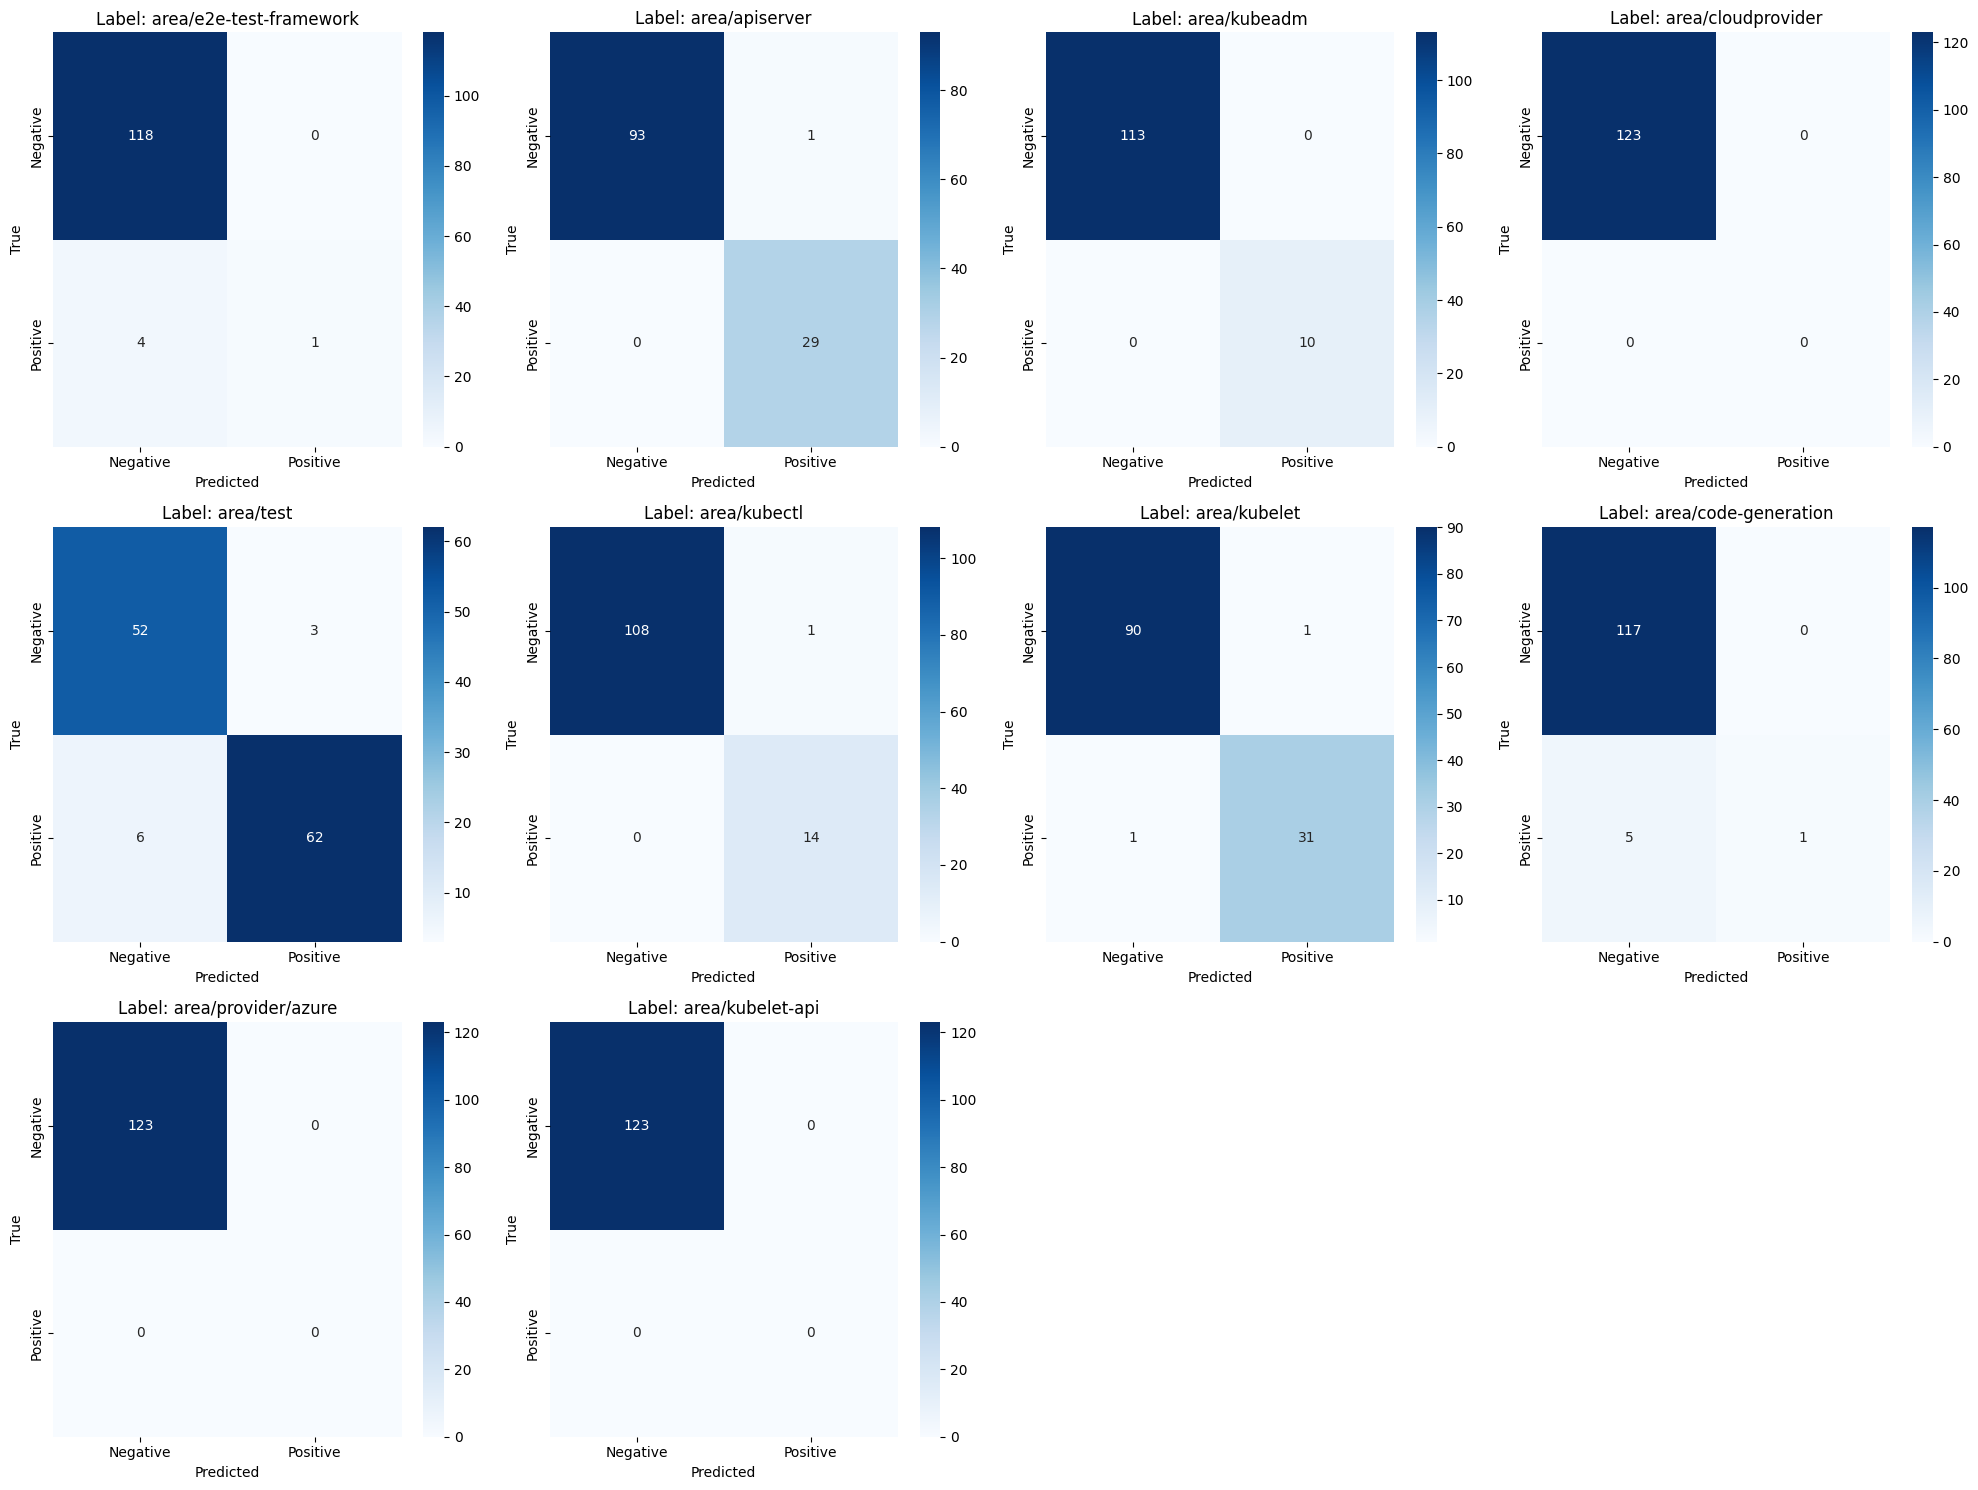

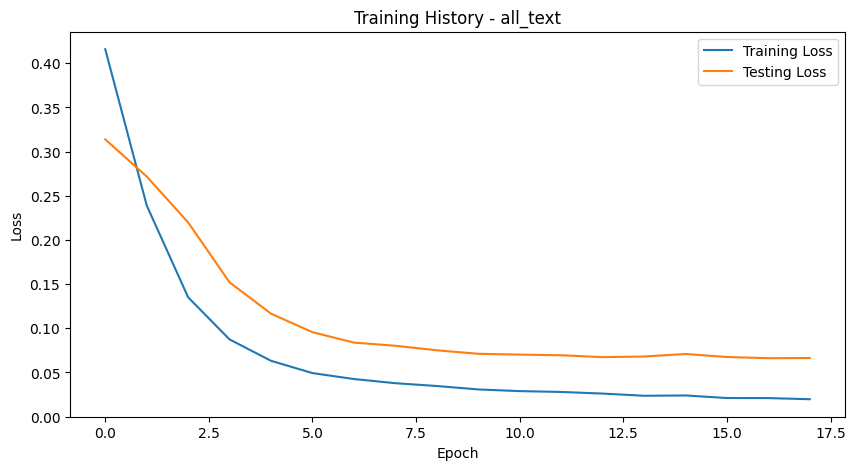

In [7]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/kubernetes-augmented-feature-request-split/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=0,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', 
                        help='Enable predefined set of 15 labels instead of using all labels')
    parser.add_argument('--use_10_labels', action='store_true', default=True,
                        help='Enable predefined set of 10 specific labels instead of using all labels')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)